# Chest X-Ray classification (adapted from assignment 1 notebook)

## Problem statement: Using pretrained ResNet-18 as the network backbone for all approaches, train the following models (evaluate all on held out test set)

### Baseline
- Train the model on real data only (100%, 10%)

### Data Augmentation (on top of all baseline, 100% and 10%)
- Geometric (hflip, affine)
- Weighted loss
- Cutmix
- Geometric + Weighted loss
- Geometric + Cutmix
- Weighted loss + Cutmix

### Synthetic
Train the model on synthetic data only

### Synthetic -> fine tune on real
- Use model pretrained on synthetic, fine tune on real (100%, 10%)

In [158]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import torch

from src import dataset
import importlib
importlib.reload(dataset)
from src import viz
import torchvision

from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

from src import train_clf

In [159]:
data_dir_real = '../data/chest_xray'
data_dir_synth = '../data/diffusion-chest-xray'

results_folder = '../results/classification'

In [160]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataloaders_real_100pct, dataset_sizes_real_100pct, class_names = dataset.load_real_downscaled_normalized_xray_data(data_dir_real, batch_size=8, return_val_set=True, load_as_rgb=True)

In [161]:
dataset_sizes_real_100pct, class_names, device

({'train': 4185, 'val': 1047, 'test': 624},
 ['NORMAL', 'PNEUMONIA'],
 device(type='cuda'))

### Visualize images from the torch dataset with transforms

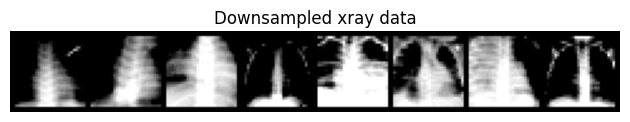

In [17]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders_real_100pct['train']))

# Select 8 images
inputs = inputs[:8]
classes = classes[:8]

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

viz.imshow(out, 0, 1, title="Downsampled xray data", save_path=f"{results_folder}/plots/downsampled_xray_data.png")

# Train models (use same hyperparams for all models)

In [195]:
lr = 0.001
momentum = 0.9
num_epochs = 20
step_size = 7
gamma = 0.1
batch_size = 32

n_outputs = 2

Note, we train the synthetic models first, because they are fine tuned on the real data later in the notebook

## (17) Synth pretrain, no geo aug, no weighted loss, no FT

In [196]:
dataloaders_all_synthetic, dataset_sizes_all_synthetic, _ = dataset.load_diffusion_normalized_xray_data(data_dir_synth, data_dir_real, with_augmentation=False, batch_size=batch_size)

In [197]:
dataset_sizes_all_synthetic

{'train': 5010, 'val': 1047, 'test': 624}

In [198]:
model_all_synthetic = resnet18(weights=ResNet18_Weights.DEFAULT)
# Change the output layer to have 2 outputs
num_ftrs = model_all_synthetic.fc.in_features
model_all_synthetic.fc = nn.Linear(num_ftrs, n_outputs)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_all_synthetic = optim.SGD(model_all_synthetic.parameters(), lr=lr, momentum=momentum)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_all_synthetic = lr_scheduler.StepLR(optimizer_all_synthetic, step_size=step_size, gamma=gamma)

In [199]:
model_all_synthetic, hist_all_synthetic = train_clf.train_model(
    model_all_synthetic, criterion, optimizer_all_synthetic, exp_lr_scheduler_all_synthetic,
    dataloaders_all_synthetic, dataset_sizes_all_synthetic, results_folder, model_name="all_synthetic", num_epochs=num_epochs)

Epoch 1/20
----------
Phase:  train
train loss: 0.3392; acc: 0.8595
Phase:  val
val loss: 0.4139; acc: 0.8052

Epoch 2/20
----------
Phase:  train
train loss: 0.2175; acc: 0.9080
Phase:  val
val loss: 0.3691; acc: 0.8548

Epoch 3/20
----------
Phase:  train
train loss: 0.1796; acc: 0.9287
Phase:  val
val loss: 0.3829; acc: 0.8395

Epoch 4/20
----------
Phase:  train
train loss: 0.1410; acc: 0.9419
Phase:  val
val loss: 0.4035; acc: 0.8395

Epoch 5/20
----------
Phase:  train
train loss: 0.1325; acc: 0.9449
Phase:  val
val loss: 0.3819; acc: 0.8376

Epoch 6/20
----------
Phase:  train
train loss: 0.1165; acc: 0.9551
Phase:  val
val loss: 0.5360; acc: 0.8071

Epoch 7/20
----------
Phase:  train
train loss: 0.0981; acc: 0.9641
Phase:  val
val loss: 0.4407; acc: 0.8472

Epoch 8/20
----------
Phase:  train
train loss: 0.0711; acc: 0.9731
Phase:  val
val loss: 0.5133; acc: 0.8252

Epoch 9/20
----------
Phase:  train
train loss: 0.0532; acc: 0.9814
Phase:  val
val loss: 0.5125; acc: 0.8281

E

In [200]:
train_loss_all_synthetic, train_acc_all_synthetic, val_loss_all_synthetic, val_acc_all_synthetic = hist_all_synthetic

#### Analyze 100% synthetic model performance

In [201]:
train_loss_all_synthetic, train_acc_all_synthetic, val_loss_all_synthetic, val_acc_all_synthetic = train_clf.load_training_metrics(f"{results_folder}/metrics/all_synthetic.npz")

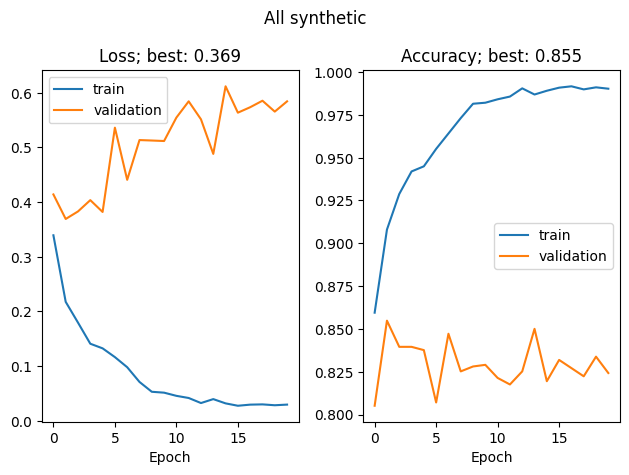

In [202]:
viz.plot_training_metrics(train_loss_all_synthetic, train_acc_all_synthetic, val_loss_all_synthetic, val_acc_all_synthetic, title="All synthetic", save_dir=f"{results_folder}/plots")

#### Evaluate 100% synthetic model on test set

In [203]:
# Load model
model_all_synthetic = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_all_synthetic.fc.in_features
model_all_synthetic.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_all_synthetic.load_state_dict(torch.load(f'{results_folder}/models/all_synthetic.pth'))

<All keys matched successfully>

In [204]:
y_true_all_synthetic, y_pred_all_synthetic, test_accuracy_all_synthetic, per_class_acc_all_synthetic = train_clf.evaluate_model_on_test_set(
    model_all_synthetic, data_loader=dataloaders_all_synthetic['test'], class_names=class_names)

Accuracy for class: PNEUMONIA is 68.2 %
Accuracy for class: NORMAL is 80.8 %
Overall accuracy (All synthetic): 72.9
Precision: 0.730
Recall: 0.745
F1 score: 0.725


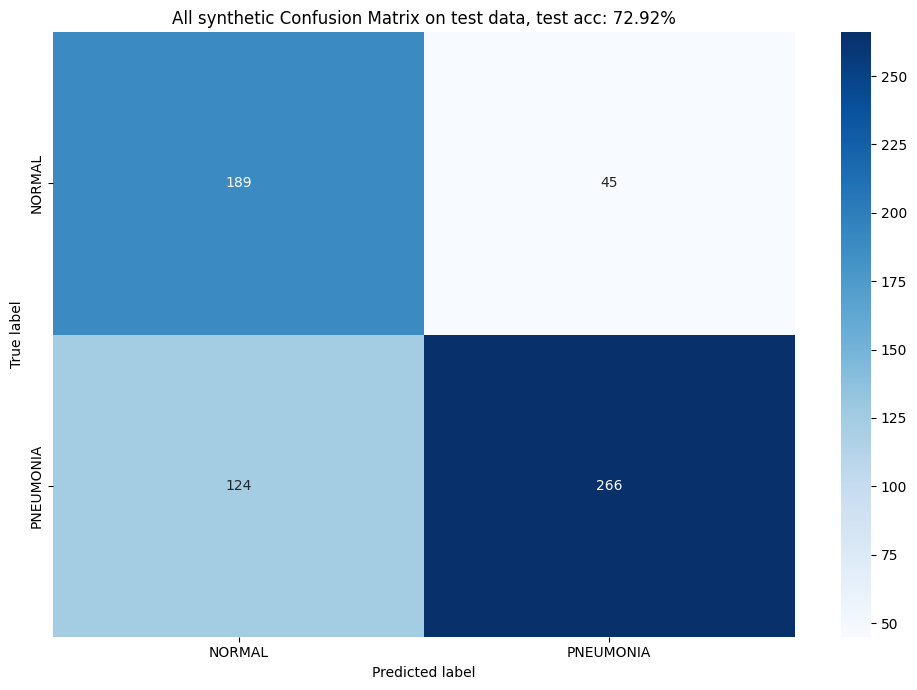

In [205]:
confusion_all_synthetic, precision_all_synthetic, recall_all_synthetic, fscore_all_synthetic, _ = train_clf.compute_metrics_on_test_set(
    y_true_all_synthetic, y_pred_all_synthetic)
viz.show_test_summary_metrics(
    test_accuracy_all_synthetic, per_class_acc_all_synthetic, confusion_all_synthetic, precision_all_synthetic, recall_all_synthetic, fscore_all_synthetic,
    "All synthetic", class_names, save_dir=f"{results_folder}/plots")

## (18) Synth pretrain, with geo aug, no weighted loss, no FT

In [206]:
dataloaders_all_synthetic_w_aug, dataset_sizes_all_synthetic_w_aug, _ = dataset.load_diffusion_normalized_xray_data(
    data_dir_synth, data_dir_real, with_augmentation=True, batch_size=batch_size)

In [207]:
dataset_sizes_all_synthetic_w_aug

{'train': 5010, 'val': 1047, 'test': 624}

In [210]:
model_all_synthetic_w_aug = resnet18(weights=ResNet18_Weights.DEFAULT)
# Change the output layer to have 2 outputs
num_ftrs = model_all_synthetic_w_aug.fc.in_features
model_all_synthetic_w_aug.fc = nn.Linear(num_ftrs, n_outputs)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_all_synthetic_w_aug = optim.SGD(model_all_synthetic_w_aug.parameters(), lr=lr, momentum=momentum)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_all_synthetic_w_aug = lr_scheduler.StepLR(optimizer_all_synthetic_w_aug, step_size=step_size, gamma=gamma)

In [211]:
model_all_synthetic_w_aug, hist_all_synthetic_w_aug = train_clf.train_model(
    model_all_synthetic_w_aug, criterion, optimizer_all_synthetic_w_aug, exp_lr_scheduler_all_synthetic_w_aug,
    dataloaders_all_synthetic_w_aug, dataset_sizes_all_synthetic_w_aug, results_folder, model_name="all_synthetic_w_aug", num_epochs=num_epochs)

Epoch 1/20
----------
Phase:  train
train loss: 0.3865; acc: 0.8313
Phase:  val
val loss: 0.3319; acc: 0.8472

Epoch 2/20
----------
Phase:  train
train loss: 0.3034; acc: 0.8665
Phase:  val
val loss: 0.3472; acc: 0.8147

Epoch 3/20
----------
Phase:  train
train loss: 0.2876; acc: 0.8792
Phase:  val
val loss: 0.4166; acc: 0.7899

Epoch 4/20
----------
Phase:  train
train loss: 0.2783; acc: 0.8864
Phase:  val
val loss: 0.3065; acc: 0.8644

Epoch 5/20
----------
Phase:  train
train loss: 0.2641; acc: 0.8862
Phase:  val
val loss: 0.3207; acc: 0.8797

Epoch 6/20
----------
Phase:  train
train loss: 0.2532; acc: 0.8890
Phase:  val
val loss: 0.3088; acc: 0.8978

Epoch 7/20
----------
Phase:  train
train loss: 0.2480; acc: 0.8974
Phase:  val
val loss: 0.3332; acc: 0.8204

Epoch 8/20
----------
Phase:  train
train loss: 0.2419; acc: 0.9000
Phase:  val
val loss: 0.3013; acc: 0.8663

Epoch 9/20
----------
Phase:  train
train loss: 0.2324; acc: 0.8996
Phase:  val
val loss: 0.3000; acc: 0.8625

E

In [212]:
train_loss_all_synthetic_w_aug, train_acc_all_synthetic_w_aug, val_loss_all_synthetic_w_aug, val_acc_all_synthetic_w_aug = hist_all_synthetic_w_aug

#### Analyze synthetic with aug model performance

In [213]:
train_loss_all_synthetic_w_aug, train_acc_all_synthetic_w_aug, val_loss_all_synthetic_w_aug, val_acc_all_synthetic_w_aug = train_clf.load_training_metrics(
    f"{results_folder}/metrics/all_synthetic_w_aug.npz")

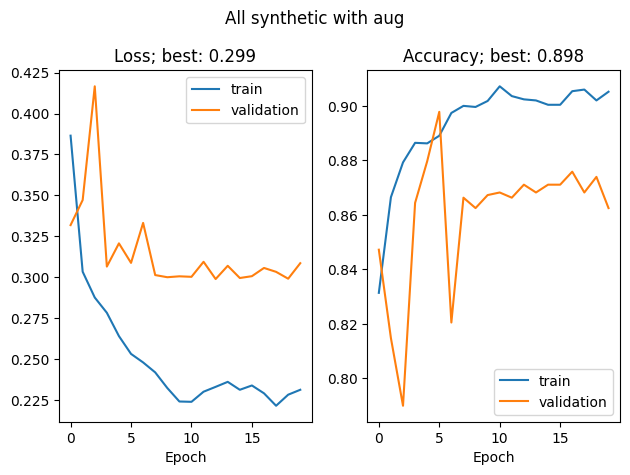

In [214]:
viz.plot_training_metrics(train_loss_all_synthetic_w_aug, train_acc_all_synthetic_w_aug, val_loss_all_synthetic_w_aug, val_acc_all_synthetic_w_aug, title="All synthetic with aug", save_dir=f"{results_folder}/plots")

#### Evaluate synthetic with aug model on test set

In [215]:
# Load model
model_all_synthetic_w_aug = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_all_synthetic_w_aug.fc.in_features
model_all_synthetic_w_aug.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_all_synthetic_w_aug.load_state_dict(torch.load(f'{results_folder}/models/all_synthetic_w_aug.pth'))

<All keys matched successfully>

In [216]:
y_true_all_synthetic_w_aug, y_pred_all_synthetic_w_aug, test_accuracy_all_synthetic_w_aug, per_class_acc_all_synthetic_w_aug = train_clf.evaluate_model_on_test_set(
    model_all_synthetic_w_aug, data_loader=dataloaders_all_synthetic_w_aug['test'], class_names=class_names)

Accuracy for class: PNEUMONIA is 62.8 %
Accuracy for class: NORMAL is 71.8 %
Overall accuracy (All synthetic with aug): 66.2
Precision: 0.662
Recall: 0.673
F1 score: 0.657


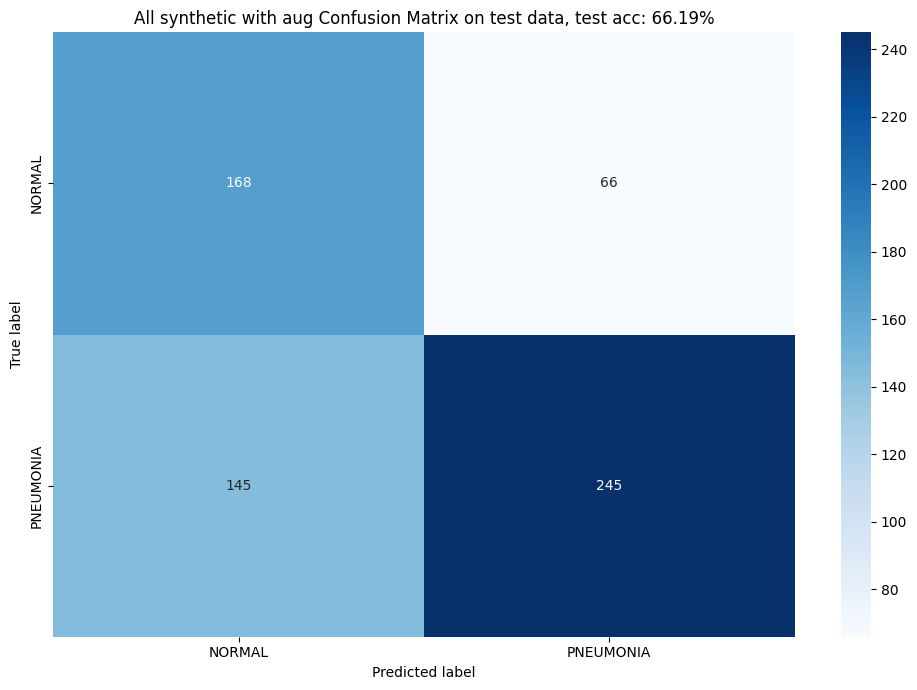

In [217]:
confusion_all_synthetic_w_aug, precision_all_synthetic_w_aug, recall_all_synthetic_w_aug, fscore_all_synthetic_w_aug, _ = train_clf.compute_metrics_on_test_set(
    y_true_all_synthetic_w_aug, y_pred_all_synthetic_w_aug)
viz.show_test_summary_metrics(
    test_accuracy_all_synthetic_w_aug, per_class_acc_all_synthetic_w_aug, confusion_all_synthetic_w_aug, precision_all_synthetic_w_aug,
    recall_all_synthetic_w_aug, fscore_all_synthetic_w_aug, "All synthetic with aug", class_names, save_dir=f"{results_folder}/plots")

## (1) 100% real, no geo data augmentation, no weighted loss, no FT

In [218]:
dataloaders_real_100pct, dataset_sizes_real_100pct, class_names = dataset.load_real_downscaled_normalized_xray_data(
    data_dir_real, batch_size=batch_size, return_val_set=True, load_as_rgb=True)

In [219]:
model_real_100pct = resnet18(weights=ResNet18_Weights.DEFAULT)
# Change the output layer to have 2 outputs
num_ftrs = model_real_100pct.fc.in_features
model_real_100pct.fc = nn.Linear(num_ftrs, n_outputs)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_real_100pct = optim.SGD(model_real_100pct.parameters(), lr=lr, momentum=momentum)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_real_100pct = lr_scheduler.StepLR(optimizer_real_100pct, step_size=step_size, gamma=gamma)

In [220]:
model_real_100pct, hist_real_100pct = train_clf.train_model(
    model_real_100pct, criterion, optimizer_real_100pct, exp_lr_scheduler_real_100pct,
    dataloaders_real_100pct, dataset_sizes_real_100pct, results_folder, model_name="real_100pct", num_epochs=num_epochs)

Epoch 1/20
----------
Phase:  train
train loss: 0.2237; acc: 0.9044
Phase:  val
val loss: 0.1204; acc: 0.9561

Epoch 2/20
----------
Phase:  train
train loss: 0.0899; acc: 0.9665
Phase:  val
val loss: 0.1055; acc: 0.9637

Epoch 3/20
----------
Phase:  train
train loss: 0.0632; acc: 0.9775
Phase:  val
val loss: 0.0990; acc: 0.9666

Epoch 4/20
----------
Phase:  train
train loss: 0.0402; acc: 0.9847
Phase:  val
val loss: 0.0916; acc: 0.9733

Epoch 5/20
----------
Phase:  train
train loss: 0.0234; acc: 0.9916
Phase:  val
val loss: 0.0977; acc: 0.9666

Epoch 6/20
----------
Phase:  train
train loss: 0.0258; acc: 0.9904
Phase:  val
val loss: 0.0977; acc: 0.9742

Epoch 7/20
----------
Phase:  train
train loss: 0.0212; acc: 0.9947
Phase:  val
val loss: 0.1299; acc: 0.9675

Epoch 8/20
----------
Phase:  train
train loss: 0.0169; acc: 0.9947
Phase:  val
val loss: 0.1005; acc: 0.9752

Epoch 9/20
----------
Phase:  train
train loss: 0.0097; acc: 0.9971
Phase:  val
val loss: 0.1179; acc: 0.9704

E

In [221]:
train_loss_real_100pct, train_acc_real_100pct, val_loss_real_100pct, val_acc_real_100pct = hist_real_100pct

#### Analyze 100% real model performance

In [222]:
train_loss_real_100pct, train_acc_real_100pct, val_loss_real_100pct, val_acc_real_100pct = train_clf.load_training_metrics(f"{results_folder}/metrics/real_100pct.npz")

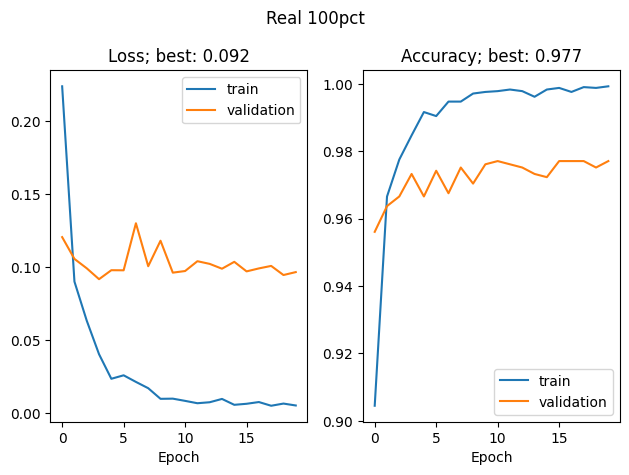

In [223]:
viz.plot_training_metrics(train_loss_real_100pct, train_acc_real_100pct, val_loss_real_100pct, val_acc_real_100pct, title="Real 100pct", save_dir=f"{results_folder}/plots")

#### Evaluate 100% real model on test set

In [224]:
# Load model
model_real_100pct = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_real_100pct.fc.in_features
model_real_100pct.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_real_100pct.load_state_dict(torch.load(f'{results_folder}/models/real_100pct.pth'))

<All keys matched successfully>

In [225]:
y_true_real_100pct, y_pred_real_100pct, test_accuracy_real_100pct, per_class_acc_real_100pct = train_clf.evaluate_model_on_test_set(model_real_100pct, data_loader=dataloaders_real_100pct['test'], class_names=class_names)

Accuracy for class: NORMAL is 53.8 %
Accuracy for class: PNEUMONIA is 97.4 %
Overall accuracy (Real 100pct): 81.1
Precision: 0.853
Recall: 0.756
F1 score: 0.773


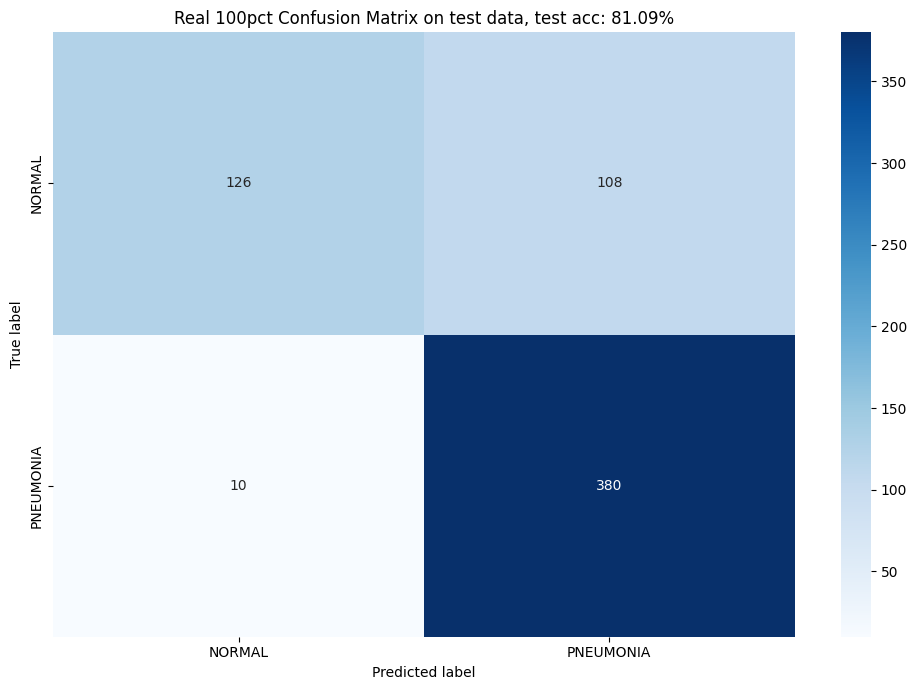

In [226]:
confusion_real_100pct, precision_real_100pct, recall_real_100pct, fscore_real_100pct, _ = train_clf.compute_metrics_on_test_set(y_true_real_100pct, y_pred_real_100pct)
viz.show_test_summary_metrics(
    test_accuracy_real_100pct, per_class_acc_real_100pct, confusion_real_100pct, precision_real_100pct, recall_real_100pct, fscore_real_100pct,
    "Real 100pct", class_names, save_dir=f"{results_folder}/plots")

## (2) 100% real, no geo data aug, weighted loss, no PT

In [227]:
labels_100pct = dataset.get_labels(dataloaders_real_100pct['train'])

In [228]:
class_weights_100pct = dataset.compute_class_weights(labels_100pct).to(device)
class_weights_100pct

tensor([0.7395, 0.2605], device='cuda:0')

In [229]:
model_real_100pct_weighted = resnet18(weights=ResNet18_Weights.DEFAULT)
# Change the output layer to have 2 outputs
num_ftrs = model_real_100pct_weighted.fc.in_features
model_real_100pct_weighted.fc = nn.Linear(num_ftrs, n_outputs)
criterion_weighted = nn.CrossEntropyLoss(weight=class_weights_100pct)
# Observe that all parameters are being optimized
optimizer_real_100pct_weighted = optim.SGD(model_real_100pct_weighted.parameters(), lr=lr, momentum=momentum)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_real_100pct_weighted = lr_scheduler.StepLR(optimizer_real_100pct_weighted, step_size=step_size, gamma=gamma)

In [230]:
model_real_100pct_weighted, hist_real_100pct_weighted = train_clf.train_model(
    model_real_100pct_weighted, criterion_weighted, optimizer_real_100pct_weighted,
    exp_lr_scheduler_real_100pct_weighted, dataloaders_real_100pct, dataset_sizes_real_100pct,
    results_folder, model_name="real_100pct_weighted", num_epochs=num_epochs)

Epoch 1/20
----------
Phase:  train
train loss: 0.2458; acc: 0.9018
Phase:  val
val loss: 0.1341; acc: 0.9513

Epoch 2/20
----------
Phase:  train
train loss: 0.1169; acc: 0.9553
Phase:  val
val loss: 0.0902; acc: 0.9694

Epoch 3/20
----------
Phase:  train
train loss: 0.0757; acc: 0.9718
Phase:  val
val loss: 0.0960; acc: 0.9637

Epoch 4/20
----------
Phase:  train
train loss: 0.0409; acc: 0.9838
Phase:  val
val loss: 0.1019; acc: 0.9656

Epoch 5/20
----------
Phase:  train
train loss: 0.0344; acc: 0.9871
Phase:  val
val loss: 0.1278; acc: 0.9666

Epoch 6/20
----------
Phase:  train
train loss: 0.0230; acc: 0.9935
Phase:  val
val loss: 0.1098; acc: 0.9685

Epoch 7/20
----------
Phase:  train
train loss: 0.0216; acc: 0.9924
Phase:  val
val loss: 0.1225; acc: 0.9713

Epoch 8/20
----------
Phase:  train
train loss: 0.0138; acc: 0.9964
Phase:  val
val loss: 0.1099; acc: 0.9713

Epoch 9/20
----------
Phase:  train
train loss: 0.0090; acc: 0.9976
Phase:  val
val loss: 0.1195; acc: 0.9666

E

#### Analyze 100% real with weighted loss model performance

In [231]:
train_loss_real_100pct_weighted, train_acc_real_100pct_weighted, val_loss_real_100pct_weighted, val_acc_real_100pct_weighted = train_clf.load_training_metrics(
    f"{results_folder}/metrics/real_100pct_weighted.npz")

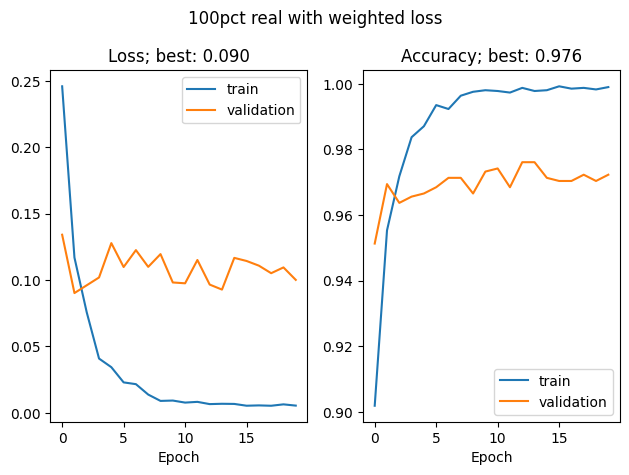

In [232]:
viz.plot_training_metrics(train_loss_real_100pct_weighted, train_acc_real_100pct_weighted, val_loss_real_100pct_weighted,
                          val_acc_real_100pct_weighted, title="100pct real with weighted loss", save_dir=f"{results_folder}/plots")

#### Evaluate 100% real with weighted loss model on test set

In [233]:
# Load model
model_real_100pct_weighted = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_real_100pct_weighted.fc.in_features
model_real_100pct_weighted.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_real_100pct_weighted.load_state_dict(torch.load(f'{results_folder}/models/real_100pct_weighted.pth'))

<All keys matched successfully>

In [234]:
y_true_real_100pct_weighted, y_pred_real_100pct_weighted, test_accuracy_real_100pct_weighted, per_class_acc_real_100pct_weighted = train_clf.evaluate_model_on_test_set(
    model_real_100pct_weighted, data_loader=dataloaders_real_100pct['test'], class_names=class_names)

Accuracy for class: NORMAL is 59.0 %
Accuracy for class: PNEUMONIA is 97.2 %
Overall accuracy (100pct real with weighted loss): 82.9
Precision: 0.862
Recall: 0.781
F1 score: 0.798


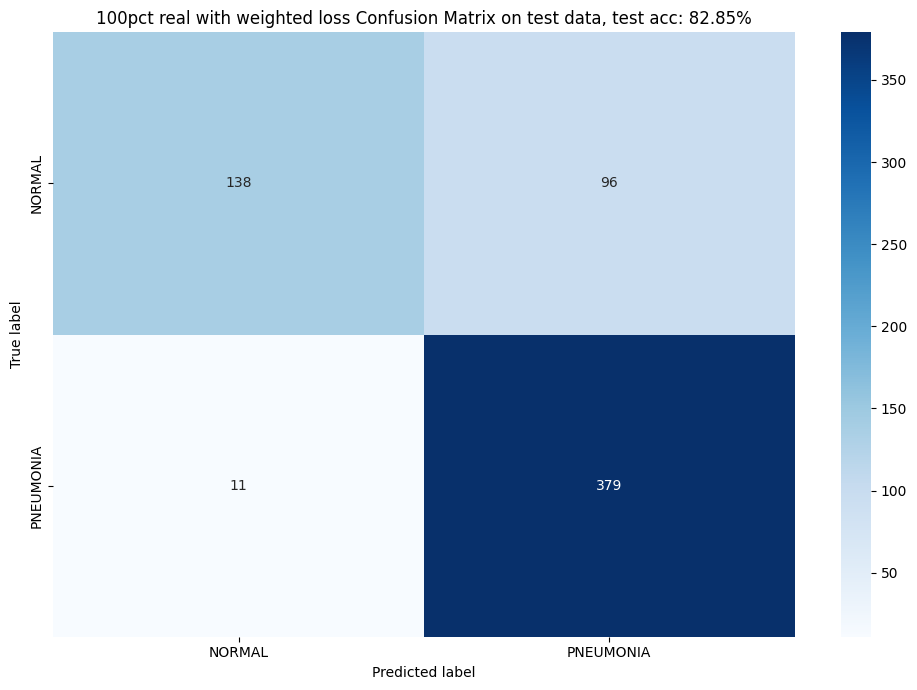

In [235]:
confusion_real_100pct_weighted, precision_real_100pct_weighted, recall_real_100pct_weighted, fscore_real_100pct_weighted, _ = train_clf.compute_metrics_on_test_set(
    y_true_real_100pct_weighted, y_pred_real_100pct_weighted)
viz.show_test_summary_metrics(
    test_accuracy_real_100pct_weighted, per_class_acc_real_100pct_weighted, confusion_real_100pct_weighted, precision_real_100pct_weighted,
    recall_real_100pct_weighted, fscore_real_100pct_weighted, "100pct real with weighted loss", class_names, save_dir=f"{results_folder}/plots")

## (3) Synth pretrain, no geo aug, no weighted loss, FT on 100% real data

In [236]:
model_synth_ft_real100pct = resnet18(weights=ResNet18_Weights.DEFAULT)
# Change the output layer to have 2 outputs
num_ftrs = model_synth_ft_real100pct.fc.in_features
model_synth_ft_real100pct.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_synth_ft_real100pct.load_state_dict(torch.load(f'{results_folder}/models/all_synthetic.pth'))

criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_synth_ft_real100pct = optim.SGD(model_synth_ft_real100pct.parameters(), lr=lr, momentum=momentum)
exp_lr_scheduler_synth_ft_real100pct = lr_scheduler.StepLR(optimizer_synth_ft_real100pct, step_size=step_size, gamma=gamma)

In [237]:
model_synth_ft_real100pct, hist_synth_ft_real100pct = train_clf.train_model(
    model_synth_ft_real100pct, criterion, optimizer_synth_ft_real100pct, exp_lr_scheduler_synth_ft_real100pct,
    dataloaders_real_100pct, dataset_sizes_real_100pct, results_folder, model_name="synth_ft_real100pct", num_epochs=num_epochs)

Epoch 1/20
----------
Phase:  train
train loss: 0.1758; acc: 0.9379
Phase:  val
val loss: 0.0893; acc: 0.9675

Epoch 2/20
----------
Phase:  train
train loss: 0.0791; acc: 0.9677
Phase:  val
val loss: 0.0683; acc: 0.9723

Epoch 3/20
----------
Phase:  train
train loss: 0.0636; acc: 0.9785
Phase:  val
val loss: 0.0675; acc: 0.9742

Epoch 4/20
----------
Phase:  train
train loss: 0.0507; acc: 0.9826
Phase:  val
val loss: 0.0752; acc: 0.9761

Epoch 5/20
----------
Phase:  train
train loss: 0.0368; acc: 0.9864
Phase:  val
val loss: 0.0816; acc: 0.9713

Epoch 6/20
----------
Phase:  train
train loss: 0.0231; acc: 0.9921
Phase:  val
val loss: 0.1026; acc: 0.9656

Epoch 7/20
----------
Phase:  train
train loss: 0.0204; acc: 0.9933
Phase:  val
val loss: 0.1060; acc: 0.9656

Epoch 8/20
----------
Phase:  train
train loss: 0.0070; acc: 0.9986
Phase:  val
val loss: 0.0846; acc: 0.9713

Epoch 9/20
----------
Phase:  train
train loss: 0.0078; acc: 0.9981
Phase:  val
val loss: 0.0748; acc: 0.9742

E

#### Analyze synthetic fine tuned on 100% real performance

In [238]:
train_loss_synth_ft_real100pct, train_acc_synth_ft_real100pct, val_loss_synth_ft_real100pct, val_acc_synth_ft_real100pct = train_clf.load_training_metrics(
    f"{results_folder}/metrics/synth_ft_real100pct.npz")

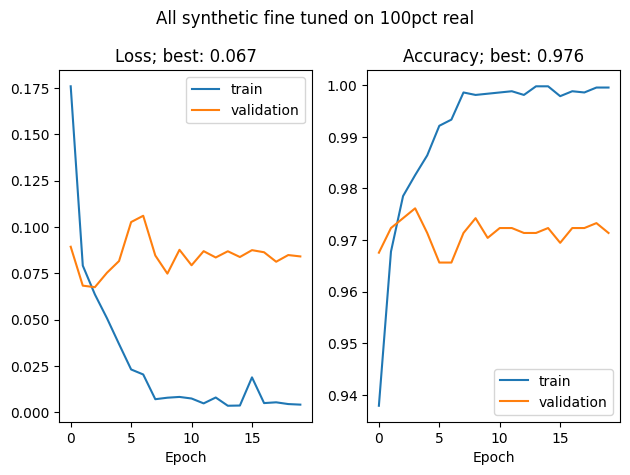

In [239]:
viz.plot_training_metrics(train_loss_synth_ft_real100pct, train_acc_synth_ft_real100pct, val_loss_synth_ft_real100pct,
                          val_acc_synth_ft_real100pct, title="All synthetic fine tuned on 100pct real", save_dir=f"{results_folder}/plots")

#### Evaluate synthetic fine tuned on 100% real model on test set

In [240]:
# Load model
model_synth_ft_real100pct = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_synth_ft_real100pct.fc.in_features
model_synth_ft_real100pct.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_synth_ft_real100pct.load_state_dict(torch.load(f'{results_folder}/models/synth_ft_real100pct.pth'))

<All keys matched successfully>

In [241]:
y_true_synth_ft_real100pct, y_pred_synth_ft_real100pct, test_accuracy_synth_ft_real100pct, per_class_acc_synth_ft_real100pct = train_clf.evaluate_model_on_test_set(
    model_synth_ft_real100pct, data_loader=dataloaders_real_100pct['test'], class_names=class_names)

Accuracy for class: NORMAL is 52.6 %
Accuracy for class: PNEUMONIA is 98.2 %
Overall accuracy (All synthetic fine tuned on 100pct real): 81.1
Precision: 0.861
Recall: 0.754
F1 score: 0.771


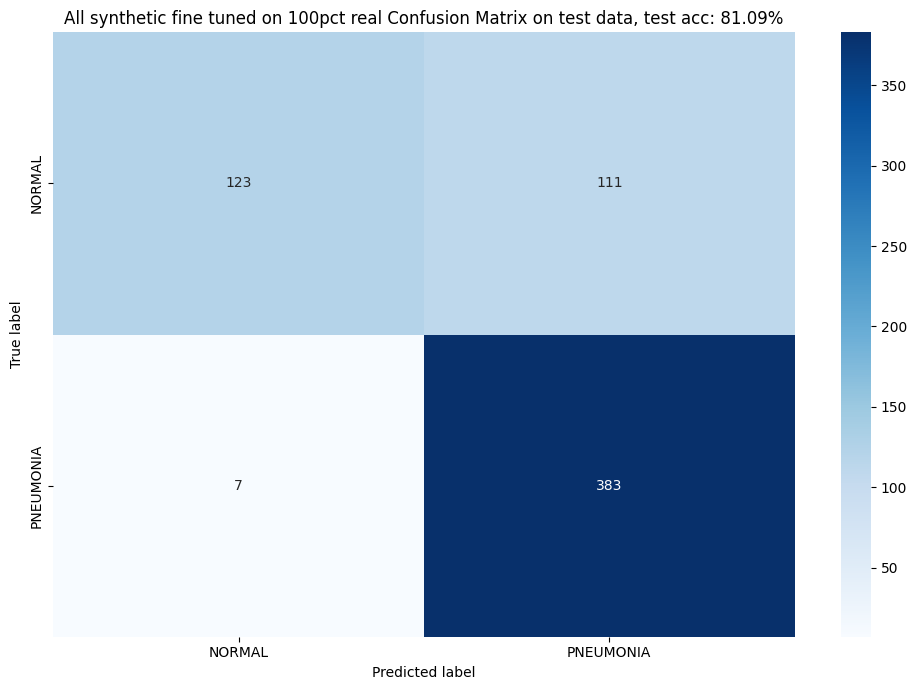

In [242]:
confusion_synth_ft_real100pct, precision_synth_ft_real100pct, recall_synth_ft_real100pct, fscore_synth_ft_real100pct, _ = train_clf.compute_metrics_on_test_set(
    y_true_synth_ft_real100pct, y_pred_synth_ft_real100pct)
viz.show_test_summary_metrics(
    test_accuracy_synth_ft_real100pct, per_class_acc_synth_ft_real100pct, confusion_synth_ft_real100pct, precision_synth_ft_real100pct,
    recall_synth_ft_real100pct, fscore_synth_ft_real100pct, "All synthetic fine tuned on 100pct real", class_names, save_dir=f"{results_folder}/plots")

## (4) Synth pretrain, no geo data aug, weighted loss, FT on 100% real

In [243]:
model_synth_ft_real_100pct_weighted = resnet18(weights=ResNet18_Weights.DEFAULT)
# Change the output layer to have 2 outputs
num_ftrs = model_synth_ft_real_100pct_weighted.fc.in_features
model_synth_ft_real_100pct_weighted.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_synth_ft_real_100pct_weighted.load_state_dict(torch.load(f'{results_folder}/models/all_synthetic.pth'))

criterion_weighted = nn.CrossEntropyLoss(weight=class_weights_100pct)
# Observe that all parameters are being optimized
optimizer_synth_ft_real_100pct_weighted = optim.SGD(model_synth_ft_real_100pct_weighted.parameters(), lr=lr, momentum=momentum)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_synth_ft_real_100pct_weighted = lr_scheduler.StepLR(optimizer_synth_ft_real_100pct_weighted, step_size=step_size, gamma=gamma)

In [244]:
model_real_100pct_weighted, hist_real_100pct_weighted = train_clf.train_model(
    model_real_100pct_weighted, criterion_weighted, optimizer_real_100pct_weighted,
    exp_lr_scheduler_real_100pct_weighted, dataloaders_real_100pct, dataset_sizes_real_100pct,
    results_folder, model_name="real_100pct_weighted", num_epochs=num_epochs)

Epoch 1/20
----------
Phase:  train
train loss: 0.0092; acc: 0.9978
Phase:  val
val loss: 0.1026; acc: 0.9733

Epoch 2/20
----------
Phase:  train
train loss: 0.0061; acc: 0.9988
Phase:  val
val loss: 0.1158; acc: 0.9694

Epoch 3/20
----------
Phase:  train
train loss: 0.0062; acc: 0.9983
Phase:  val
val loss: 0.1132; acc: 0.9685

Epoch 4/20
----------
Phase:  train
train loss: 0.0094; acc: 0.9971
Phase:  val
val loss: 0.1110; acc: 0.9704

Epoch 5/20
----------
Phase:  train
train loss: 0.0058; acc: 0.9983
Phase:  val
val loss: 0.1066; acc: 0.9713

Epoch 6/20
----------
Phase:  train
train loss: 0.0058; acc: 0.9986
Phase:  val
val loss: 0.1029; acc: 0.9713

Epoch 7/20
----------
Phase:  train
train loss: 0.0058; acc: 0.9995
Phase:  val
val loss: 0.1167; acc: 0.9685

Epoch 8/20
----------
Phase:  train
train loss: 0.0050; acc: 0.9986
Phase:  val
val loss: 0.1061; acc: 0.9694

Epoch 9/20
----------
Phase:  train
train loss: 0.0068; acc: 0.9986
Phase:  val
val loss: 0.1031; acc: 0.9704

E

#### Analyze synth pretrain, FT on 100% with weighted loss model performance

In [245]:
train_loss_real_100pct_weighted, train_acc_real_100pct_weighted, val_loss_real_100pct_weighted, val_acc_real_100pct_weighted = train_clf.load_training_metrics(
    f"{results_folder}/metrics/real_100pct_weighted.npz")

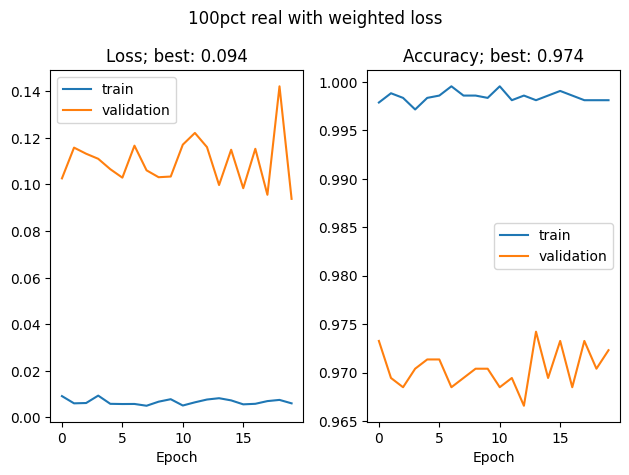

In [246]:
viz.plot_training_metrics(train_loss_real_100pct_weighted, train_acc_real_100pct_weighted, val_loss_real_100pct_weighted,
                          val_acc_real_100pct_weighted, title="100pct real with weighted loss", save_dir=f"{results_folder}/plots")

#### Evaluate synth pretrain, FT on 100% with weighted loss model on test set

In [247]:
# Load model
model_real_100pct_weighted = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_real_100pct_weighted.fc.in_features
model_real_100pct_weighted.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_real_100pct_weighted.load_state_dict(torch.load(f'{results_folder}/models/real_100pct_weighted.pth'))

<All keys matched successfully>

In [248]:
y_true_real_100pct_weighted, y_pred_real_100pct_weighted, test_accuracy_real_100pct_weighted, per_class_acc_real_100pct_weighted = train_clf.evaluate_model_on_test_set(
    model_real_100pct_weighted, data_loader=dataloaders_real_100pct['test'], class_names=class_names)

Accuracy for class: NORMAL is 58.5 %
Accuracy for class: PNEUMONIA is 97.4 %
Overall accuracy (100pct real with weighted loss): 82.9
Precision: 0.864
Recall: 0.780
F1 score: 0.798


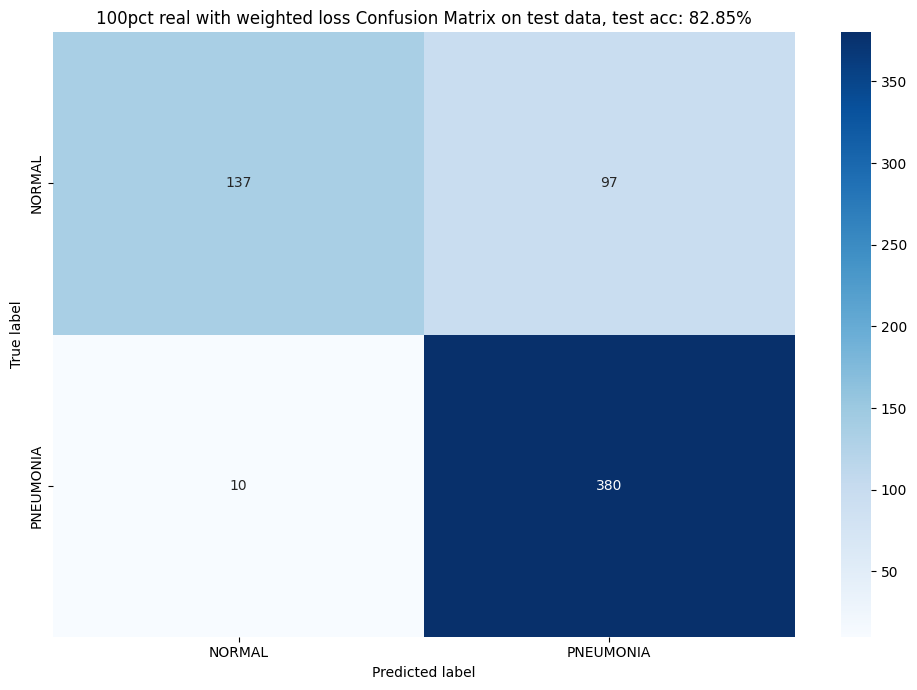

In [249]:
confusion_real_100pct_weighted, precision_real_100pct_weighted, recall_real_100pct_weighted, fscore_real_100pct_weighted, _ = train_clf.compute_metrics_on_test_set(
    y_true_real_100pct_weighted, y_pred_real_100pct_weighted)
viz.show_test_summary_metrics(
    test_accuracy_real_100pct_weighted, per_class_acc_real_100pct_weighted, confusion_real_100pct_weighted, precision_real_100pct_weighted,
    recall_real_100pct_weighted, fscore_real_100pct_weighted, "100pct real with weighted loss", class_names, save_dir=f"{results_folder}/plots")

## (5) 100% real, geometric data augmentation, no weighted loss, no PT

In [250]:
dataloaders_real_100pct_geo_aug, dataset_sizes_real_100pct_geo_aug, _ = dataset.load_real_downscaled_normalized_xray_data(
    data_dir_real, with_augmentation=True, batch_size=batch_size, return_val_set=True, load_as_rgb=True)

In [251]:
dataset_sizes_real_100pct_geo_aug

{'train': 4185, 'val': 1047, 'test': 624}

In [252]:
model_real_100pct_geo_aug = resnet18(weights=ResNet18_Weights.DEFAULT)
# Change the output layer to have 2 outputs
num_ftrs = model_real_100pct_geo_aug.fc.in_features
model_real_100pct_geo_aug.fc = nn.Linear(num_ftrs, n_outputs)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_real_100pct_geo_aug = optim.SGD(model_real_100pct_geo_aug.parameters(), lr=lr, momentum=momentum)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_real_100pct_geo_aug = lr_scheduler.StepLR(optimizer_real_100pct_geo_aug, step_size=step_size, gamma=gamma)

In [253]:
model_real_100pct_geo_aug, hist_real_100pct_geo_aug = train_clf.train_model(
    model_real_100pct_geo_aug, criterion, optimizer_real_100pct_geo_aug, exp_lr_scheduler_real_100pct_geo_aug,
    dataloaders_real_100pct_geo_aug, dataset_sizes_real_100pct_geo_aug, results_folder, model_name="real_100pct_geo_aug", num_epochs=num_epochs)

Epoch 1/20
----------
Phase:  train
train loss: 0.5028; acc: 0.7740
Phase:  val
val loss: 0.4387; acc: 0.8109

Epoch 2/20
----------
Phase:  train
train loss: 0.3927; acc: 0.8303
Phase:  val
val loss: 0.3794; acc: 0.8252

Epoch 3/20
----------
Phase:  train
train loss: 0.3400; acc: 0.8502
Phase:  val
val loss: 0.3521; acc: 0.8338

Epoch 4/20
----------
Phase:  train
train loss: 0.3296; acc: 0.8538
Phase:  val
val loss: 0.3573; acc: 0.8300

Epoch 5/20
----------
Phase:  train
train loss: 0.3271; acc: 0.8600
Phase:  val
val loss: 0.3247; acc: 0.8567

Epoch 6/20
----------
Phase:  train
train loss: 0.3145; acc: 0.8616
Phase:  val
val loss: 0.3324; acc: 0.8606

Epoch 7/20
----------
Phase:  train
train loss: 0.3029; acc: 0.8681
Phase:  val
val loss: 0.3137; acc: 0.8701

Epoch 8/20
----------
Phase:  train
train loss: 0.2960; acc: 0.8683
Phase:  val
val loss: 0.3068; acc: 0.8539

Epoch 9/20
----------
Phase:  train
train loss: 0.2866; acc: 0.8736
Phase:  val
val loss: 0.2993; acc: 0.8711

E

#### Analyze 100% real with geo aug model performance

In [254]:
train_loss_real_100pct_geo_aug, train_acc_real_100pct_geo_aug, val_loss_real_100pct_geo_aug, val_acc_real_100pct_geo_aug = train_clf.load_training_metrics(f"{results_folder}/metrics/real_100pct_geo_aug.npz")

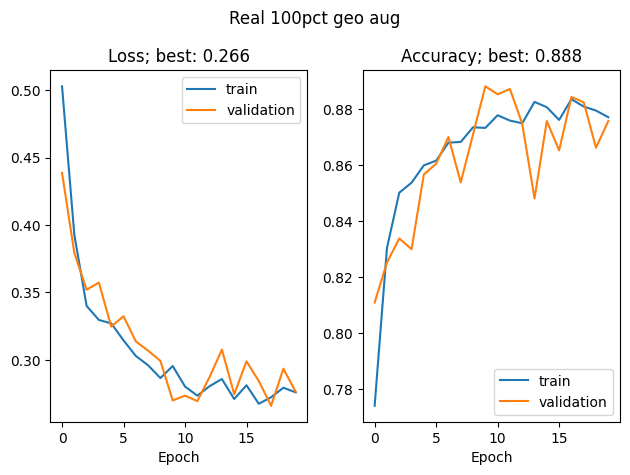

In [255]:
viz.plot_training_metrics(train_loss_real_100pct_geo_aug, train_acc_real_100pct_geo_aug, val_loss_real_100pct_geo_aug,
                          val_acc_real_100pct_geo_aug, title="Real 100pct geo aug", save_dir=f"{results_folder}/plots")

#### Evaluate 100% real with geo aug model on test set

In [256]:
# Load model
model_real_100pct_geo_aug = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_real_100pct_geo_aug.fc.in_features
model_real_100pct_geo_aug.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_real_100pct_geo_aug.load_state_dict(torch.load(f'{results_folder}/models/real_100pct_geo_aug.pth'))

<All keys matched successfully>

In [257]:
y_true_real_100pct_geo_aug, y_pred_real_100pct_geo_aug, test_accuracy_real_100pct_geo_aug, per_class_acc_real_100pct_geo_aug = train_clf.evaluate_model_on_test_set(
    model_real_100pct_geo_aug, data_loader=dataloaders_real_100pct_geo_aug['test'], class_names=class_names)

Accuracy for class: NORMAL is 65.0 %
Accuracy for class: PNEUMONIA is 93.3 %
Overall accuracy (Real 100pct geo aug): 82.7
Precision: 0.835
Recall: 0.791
F1 score: 0.804


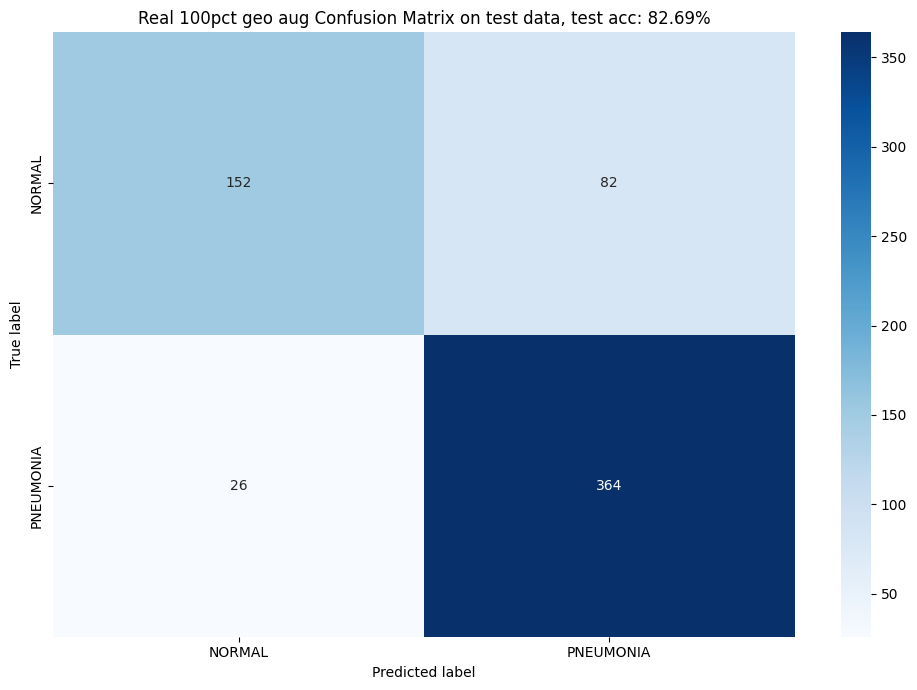

In [258]:
confusion_real_100pct_geo_aug, precision_real_100pct_geo_aug, recall_real_100pct_geo_aug, fscore_real_100pct_geo_aug, _ = train_clf.compute_metrics_on_test_set(
    y_true_real_100pct_geo_aug, y_pred_real_100pct_geo_aug)
viz.show_test_summary_metrics(
    test_accuracy_real_100pct_geo_aug, per_class_acc_real_100pct_geo_aug, confusion_real_100pct_geo_aug,
    precision_real_100pct_geo_aug, recall_real_100pct_geo_aug, fscore_real_100pct_geo_aug,
    "Real 100pct geo aug", class_names, save_dir=f"{results_folder}/plots")

## (6) 100% real, geo data aug, weighted loss, no PT

In [259]:
model_real_100pct_weighted_geo_aug = resnet18(weights=ResNet18_Weights.DEFAULT)
# Change the output layer to have 2 outputs
num_ftrs = model_real_100pct_weighted_geo_aug.fc.in_features
model_real_100pct_weighted_geo_aug.fc = nn.Linear(num_ftrs, n_outputs)
criterion_weighted = nn.CrossEntropyLoss(weight=class_weights_100pct)
# Observe that all parameters are being optimized
optimizer_real_100pct_weighted_geo_aug = optim.SGD(model_real_100pct_weighted_geo_aug.parameters(), lr=lr, momentum=momentum)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_real_100pct_weighted_geo_aug = lr_scheduler.StepLR(optimizer_real_100pct_weighted_geo_aug, step_size=step_size, gamma=gamma)

In [260]:
model_real_100pct_weighted_geo_aug, hist_real_100pct_weighted_geo_aug = train_clf.train_model(
    model_real_100pct_weighted_geo_aug, criterion_weighted, optimizer_real_100pct_weighted_geo_aug,
    exp_lr_scheduler_real_100pct_weighted_geo_aug, dataloaders_10pct_train, dataset_sizes_10pct_train,
    results_folder, model_name="real_100pct_weighted_geo_aug", num_epochs=num_epochs)

Epoch 1/20
----------
Phase:  train
train loss: 0.5641; acc: 0.6675
Phase:  val
val loss: 0.3435; acc: 0.8930

Epoch 2/20
----------
Phase:  train
train loss: 0.3868; acc: 0.8589
Phase:  val
val loss: 0.7061; acc: 0.8080

Epoch 3/20
----------
Phase:  train
train loss: 0.5076; acc: 0.7919
Phase:  val
val loss: 3.0979; acc: 0.7373

Epoch 4/20
----------
Phase:  train
train loss: 0.3256; acc: 0.8923
Phase:  val
val loss: 0.9140; acc: 0.8052

Epoch 5/20
----------
Phase:  train
train loss: 0.2966; acc: 0.8852
Phase:  val
val loss: 0.7286; acc: 0.8711

Epoch 6/20
----------
Phase:  train
train loss: 0.1935; acc: 0.9091
Phase:  val
val loss: 0.2931; acc: 0.8577

Epoch 7/20
----------
Phase:  train
train loss: 0.2014; acc: 0.8971
Phase:  val
val loss: 0.6730; acc: 0.7861

Epoch 8/20
----------
Phase:  train
train loss: 0.2086; acc: 0.9354
Phase:  val
val loss: 0.2661; acc: 0.8949

Epoch 9/20
----------
Phase:  train
train loss: 0.1834; acc: 0.9354
Phase:  val
val loss: 0.2399; acc: 0.8921

E

#### Analyze 100% real, geo aug + weighted loss model performance

In [261]:
train_loss_real_100pct_weighted, train_acc_real_100pct_weighted, val_loss_real_100pct_weighted, val_acc_real_100pct_weighted = train_clf.load_training_metrics(
    f"{results_folder}/metrics/real_100pct_weighted.npz")

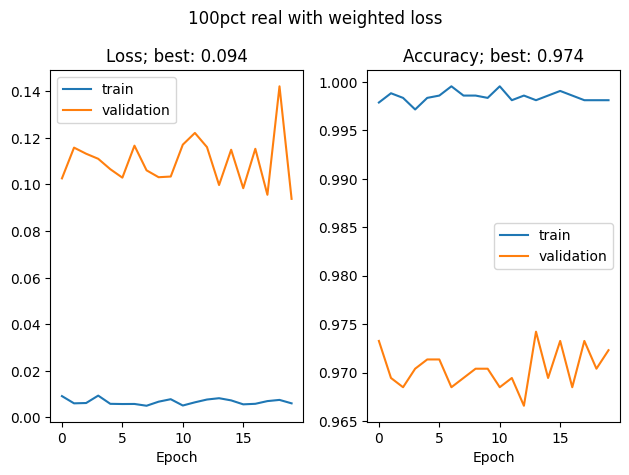

In [262]:
viz.plot_training_metrics(train_loss_real_100pct_weighted, train_acc_real_100pct_weighted, val_loss_real_100pct_weighted,
                          val_acc_real_100pct_weighted, title="100pct real with weighted loss", save_dir=f"{results_folder}/plots")

#### Evaluate 100% real, geo aug + weighted loss model on test set

In [263]:
# Load model
model_real_100pct_weighted = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_real_100pct_weighted.fc.in_features
model_real_100pct_weighted.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_real_100pct_weighted.load_state_dict(torch.load(f'{results_folder}/models/real_100pct_weighted.pth'))

<All keys matched successfully>

In [264]:
y_true_real_100pct_weighted, y_pred_real_100pct_weighted, test_accuracy_real_100pct_weighted, per_class_acc_real_100pct_weighted = train_clf.evaluate_model_on_test_set(
    model_real_100pct_weighted, data_loader=dataloaders_real_100pct['test'], class_names=class_names)

Accuracy for class: NORMAL is 61.5 %
Accuracy for class: PNEUMONIA is 97.7 %
Overall accuracy (100pct real with weighted loss): 84.1
Precision: 0.875
Recall: 0.796
F1 score: 0.815


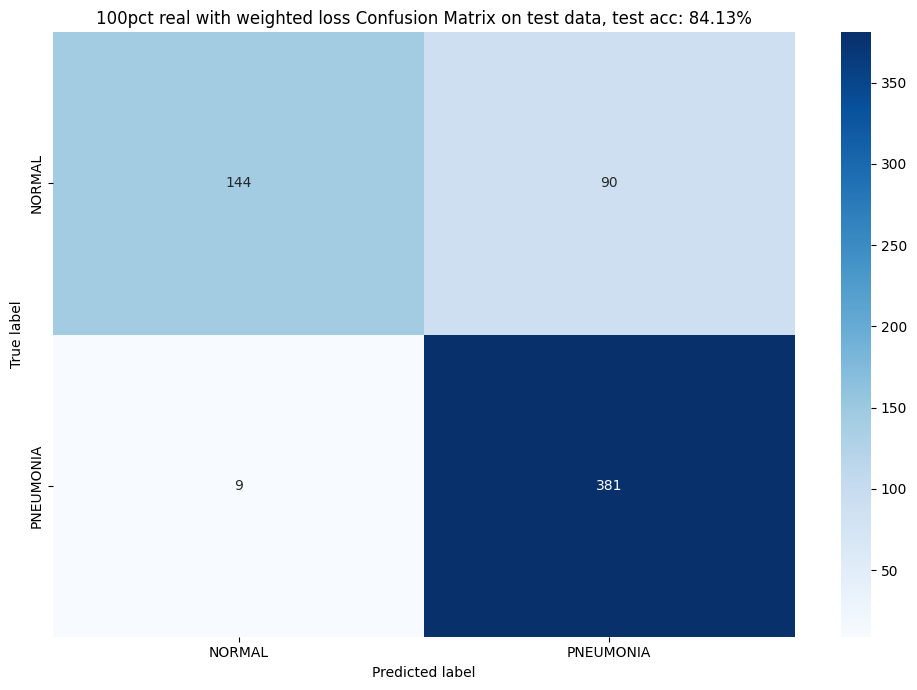

In [265]:
confusion_real_100pct_weighted, precision_real_100pct_weighted, recall_real_100pct_weighted, fscore_real_100pct_weighted, _ = train_clf.compute_metrics_on_test_set(
    y_true_real_100pct_weighted, y_pred_real_100pct_weighted)
viz.show_test_summary_metrics(
    test_accuracy_real_100pct_weighted, per_class_acc_real_100pct_weighted, confusion_real_100pct_weighted, precision_real_100pct_weighted,
    recall_real_100pct_weighted, fscore_real_100pct_weighted, "100pct real with weighted loss", class_names, save_dir=f"{results_folder}/plots")

## (7) Synth pretrain, geo data aug, no weighted loss, FT on 100% real

In [266]:
model_synth_ft_real_100pct_geo_aug = resnet18(weights=ResNet18_Weights.DEFAULT)
# Change the output layer to have 2 outputs
num_ftrs = model_synth_ft_real_100pct_geo_aug.fc.in_features
model_synth_ft_real_100pct_geo_aug.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_synth_ft_real_100pct_geo_aug.load_state_dict(torch.load(f'{results_folder}/models/all_synthetic.pth'))

criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_synth_ft_real_100pct_geo_aug = optim.SGD(model_synth_ft_real_100pct_geo_aug.parameters(), lr=lr, momentum=momentum)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_synth_ft_real_100pct_geo_aug = lr_scheduler.StepLR(optimizer_synth_ft_real_100pct_geo_aug, step_size=step_size, gamma=gamma)

In [267]:
model_synth_ft_real_100pct_geo_aug, hist_synth_ft_real_100pct_geo_aug = train_clf.train_model(
    model_synth_ft_real_100pct_geo_aug, criterion, optimizer_synth_ft_real_100pct_geo_aug,
    exp_lr_scheduler_synth_ft_real_100pct_geo_aug, dataloaders_real_100pct_geo_aug,
    dataset_sizes_real_100pct_geo_aug, results_folder, model_name="synth_ft_real_100pct_geo_aug",
    num_epochs=num_epochs)

Epoch 1/20
----------
Phase:  train
train loss: 0.4974; acc: 0.7995
Phase:  val
val loss: 0.3667; acc: 0.8434

Epoch 2/20
----------
Phase:  train
train loss: 0.3665; acc: 0.8289
Phase:  val
val loss: 0.3266; acc: 0.8529

Epoch 3/20
----------
Phase:  train
train loss: 0.3527; acc: 0.8394
Phase:  val
val loss: 0.3378; acc: 0.8424

Epoch 4/20
----------
Phase:  train
train loss: 0.3260; acc: 0.8576
Phase:  val
val loss: 0.3337; acc: 0.8462

Epoch 5/20
----------
Phase:  train
train loss: 0.3218; acc: 0.8554
Phase:  val
val loss: 0.2846; acc: 0.8768

Epoch 6/20
----------
Phase:  train
train loss: 0.3151; acc: 0.8564
Phase:  val
val loss: 0.3028; acc: 0.8644

Epoch 7/20
----------
Phase:  train
train loss: 0.3082; acc: 0.8662
Phase:  val
val loss: 0.2794; acc: 0.8844

Epoch 8/20
----------
Phase:  train
train loss: 0.2848; acc: 0.8736
Phase:  val
val loss: 0.2820; acc: 0.8816

Epoch 9/20
----------
Phase:  train
train loss: 0.2796; acc: 0.8757
Phase:  val
val loss: 0.2807; acc: 0.8768

E

#### Analyze synth PT, FT on 100% real, geo aug, no weighted loss model performance

In [268]:
train_loss_synth_ft_real_100pct_geo_aug, train_acc_synth_ft_real_100pct_geo_aug, val_loss_synth_ft_real_100pct_geo_aug, val_acc_synth_ft_real_100pct_geo_aug = train_clf.load_training_metrics(
    f"{results_folder}/metrics/synth_ft_real_100pct_geo_aug.npz")

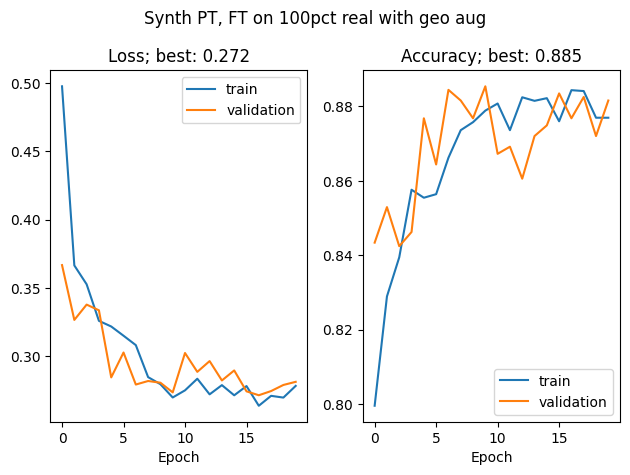

In [269]:
viz.plot_training_metrics(train_loss_synth_ft_real_100pct_geo_aug, train_acc_synth_ft_real_100pct_geo_aug, val_loss_synth_ft_real_100pct_geo_aug,
                          val_acc_synth_ft_real_100pct_geo_aug, title="Synth PT, FT on 100pct real with geo aug", save_dir=f"{results_folder}/plots")

#### Evaluate model on test set

In [270]:
# Load model
model_synth_ft_real_100pct_geo_aug = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_synth_ft_real_100pct_geo_aug.fc.in_features
model_synth_ft_real_100pct_geo_aug.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_synth_ft_real_100pct_geo_aug.load_state_dict(torch.load(f'{results_folder}/models/synth_ft_real_100pct_geo_aug.pth'))

<All keys matched successfully>

In [271]:
y_true_synth_ft_real_100pct_geo_aug, y_pred_synth_ft_real_100pct_geo_aug, test_accuracy_synth_ft_real_100pct_geo_aug, per_class_acc_synth_ft_real_100pct_geo_aug = train_clf.evaluate_model_on_test_set(
    model_synth_ft_real_100pct_geo_aug, data_loader=dataloaders_real_100pct_geo_aug['test'], class_names=class_names)

Accuracy for class: NORMAL is 64.5 %
Accuracy for class: PNEUMONIA is 94.1 %
Overall accuracy (Synth PT, FT on 100pct real with geo aug): 83.0
Precision: 0.842
Recall: 0.793
F1 score: 0.807


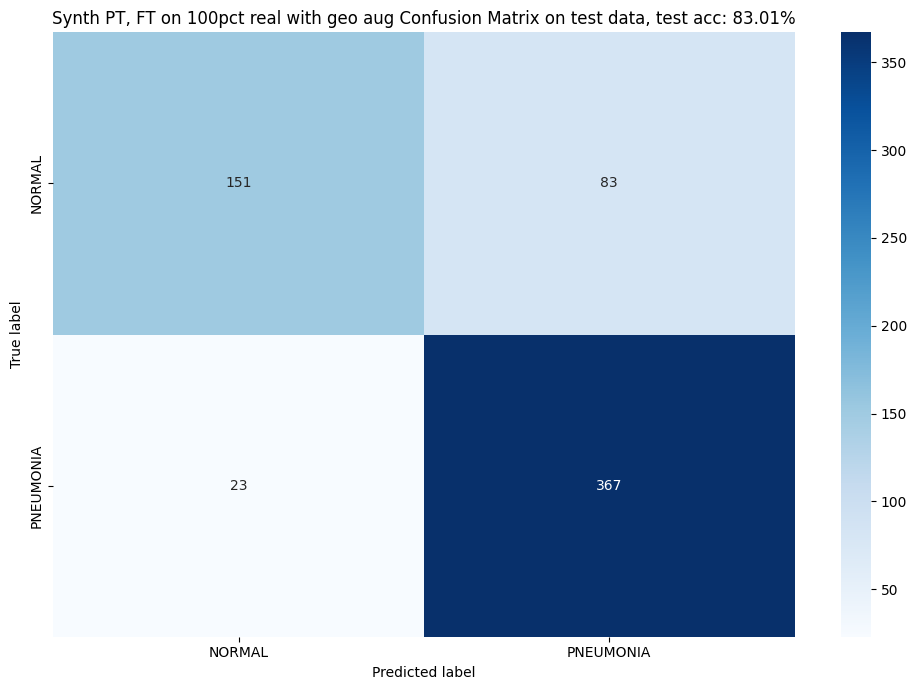

In [272]:
confusion_synth_ft_real_100pct_geo_aug, precision_synth_ft_real_100pct_geo_aug, recall_synth_ft_real_100pct_geo_aug, fscore_synth_ft_real_100pct_geo_aug, _ = train_clf.compute_metrics_on_test_set(
    y_true_synth_ft_real_100pct_geo_aug, y_pred_synth_ft_real_100pct_geo_aug)
viz.show_test_summary_metrics(
    test_accuracy_synth_ft_real_100pct_geo_aug, per_class_acc_synth_ft_real_100pct_geo_aug, confusion_synth_ft_real_100pct_geo_aug, precision_synth_ft_real_100pct_geo_aug,
    recall_synth_ft_real_100pct_geo_aug, fscore_synth_ft_real_100pct_geo_aug, "Synth PT, FT on 100pct real with geo aug", class_names, save_dir=f"{results_folder}/plots")

## (8) Synth pretrain, geo data aug, weighted loss, FT on 100% real

In [273]:
model_synth_ft_real_100pct_weighted_geo_aug = resnet18(weights=ResNet18_Weights.DEFAULT)
# Change the output layer to have 2 outputs
num_ftrs = model_synth_ft_real_100pct_weighted_geo_aug.fc.in_features
model_synth_ft_real_100pct_weighted_geo_aug.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_synth_ft_real_100pct_weighted_geo_aug.load_state_dict(torch.load(f'{results_folder}/models/all_synthetic.pth'))

criterion_weighted = nn.CrossEntropyLoss(weight=class_weights_100pct)
# Observe that all parameters are being optimized
optimizer_synth_ft_real_100pct_weighted_geo_aug = optim.SGD(model_synth_ft_real_100pct_weighted_geo_aug.parameters(), lr=lr, momentum=momentum)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_synth_ft_real_100pct_weighted_geo_aug = lr_scheduler.StepLR(optimizer_synth_ft_real_100pct_weighted_geo_aug, step_size=step_size, gamma=gamma)

In [274]:
model_synth_ft_real_100pct_weighted_geo_aug, hist_synth_ft_real_100pct_weighted_geo_aug = train_clf.train_model(
    model_synth_ft_real_100pct_weighted_geo_aug, criterion_weighted, optimizer_synth_ft_real_100pct_weighted_geo_aug,
    exp_lr_scheduler_synth_ft_real_100pct_weighted_geo_aug, dataloaders_real_100pct_geo_aug, dataset_sizes_real_100pct_geo_aug,
    results_folder, model_name="synth_ft_real_100pct_weighted_geo_aug", num_epochs=num_epochs)

Epoch 1/20
----------
Phase:  train
train loss: 0.5416; acc: 0.7720
Phase:  val
val loss: 0.4584; acc: 0.8023

Epoch 2/20
----------
Phase:  train
train loss: 0.4406; acc: 0.8117
Phase:  val
val loss: 0.4116; acc: 0.7794

Epoch 3/20
----------
Phase:  train
train loss: 0.4044; acc: 0.8131
Phase:  val
val loss: 0.3939; acc: 0.8166

Epoch 4/20
----------
Phase:  train
train loss: 0.3853; acc: 0.8237
Phase:  val
val loss: 0.4080; acc: 0.8481

Epoch 5/20
----------
Phase:  train
train loss: 0.3821; acc: 0.8370
Phase:  val
val loss: 0.3535; acc: 0.8415

Epoch 6/20
----------
Phase:  train
train loss: 0.3616; acc: 0.8358
Phase:  val
val loss: 0.3463; acc: 0.8529

Epoch 7/20
----------
Phase:  train
train loss: 0.3463; acc: 0.8471
Phase:  val
val loss: 0.3678; acc: 0.8777

Epoch 8/20
----------
Phase:  train
train loss: 0.3297; acc: 0.8516
Phase:  val
val loss: 0.3287; acc: 0.8644

Epoch 9/20
----------
Phase:  train
train loss: 0.3368; acc: 0.8430
Phase:  val
val loss: 0.3328; acc: 0.8529

E

#### Analyze synth PT, FT on 100% real, geo aug + weighted loss model performance

In [275]:
train_loss_synth_ft_real_100pct_weighted_geo_aug, train_acc_synth_ft_real_100pct_weighted_geo_aug, val_loss_synth_ft_real_100pct_weighted_geo_aug, val_acc_synth_ft_real_100pct_weighted_geo_aug = train_clf.load_training_metrics(
    f"{results_folder}/metrics/synth_ft_real_100pct_weighted_geo_aug.npz")

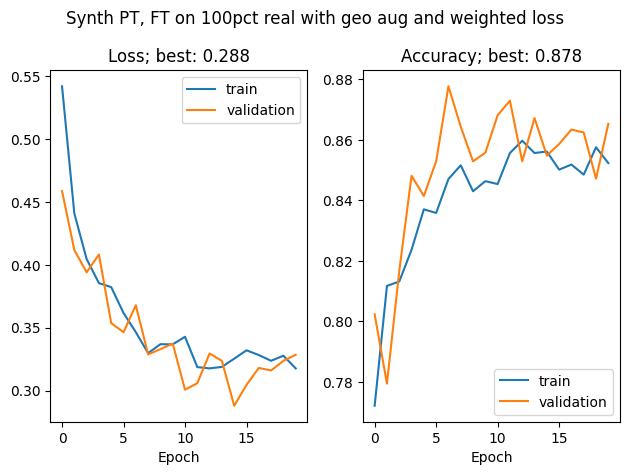

In [276]:
viz.plot_training_metrics(train_loss_synth_ft_real_100pct_weighted_geo_aug, train_acc_synth_ft_real_100pct_weighted_geo_aug, val_loss_synth_ft_real_100pct_weighted_geo_aug,
                          val_acc_synth_ft_real_100pct_weighted_geo_aug, title="Synth PT, FT on 100pct real with geo aug and weighted loss", save_dir=f"{results_folder}/plots")

#### Evaluate synth PT, FT on 100% real, geo aug + weighted loss model on test set

In [277]:
# Load model
model_synth_ft_real_100pct_weighted_geo_aug = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_synth_ft_real_100pct_weighted_geo_aug.fc.in_features
model_synth_ft_real_100pct_weighted_geo_aug.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_synth_ft_real_100pct_weighted_geo_aug.load_state_dict(torch.load(f'{results_folder}/models/synth_ft_real_100pct_weighted_geo_aug.pth'))

<All keys matched successfully>

In [278]:
y_true_synth_ft_real_100pct_weighted_geo_aug, y_pred_synth_ft_real_100pct_weighted_geo_aug, test_accuracy_synth_ft_real_100pct_weighted_geo_aug, per_class_acc_synth_ft_real_100pct_weighted_geo_aug = train_clf.evaluate_model_on_test_set(
    model_synth_ft_real_100pct_weighted_geo_aug, data_loader=dataloaders_real_100pct_geo_aug['test'], class_names=class_names)

Accuracy for class: NORMAL is 70.5 %
Accuracy for class: PNEUMONIA is 89.5 %
Overall accuracy (Synth PT, FT on 100pct real with geo aug and weighted loss): 82.4
Precision: 0.818
Recall: 0.800
F1 score: 0.807


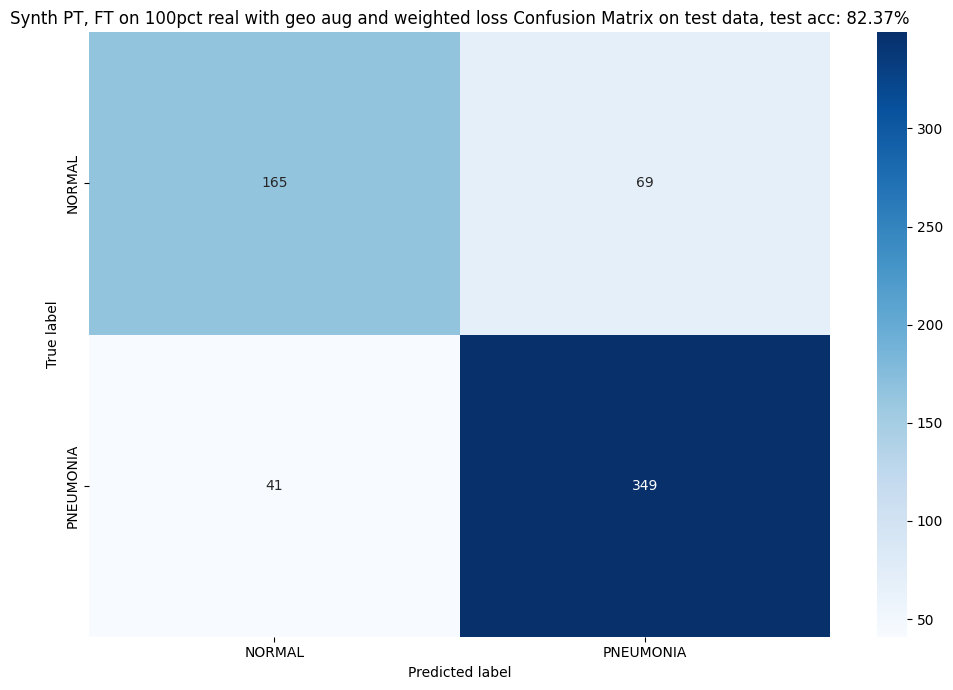

In [279]:
confusion_synth_ft_real_100pct_weighted_geo_aug, precision_synth_ft_real_100pct_weighted_geo_aug, recall_synth_ft_real_100pct_weighted_geo_aug, fscore_synth_ft_real_100pct_weighted_geo_aug, _ = train_clf.compute_metrics_on_test_set(
    y_true_synth_ft_real_100pct_weighted_geo_aug, y_pred_synth_ft_real_100pct_weighted_geo_aug)
viz.show_test_summary_metrics(
    test_accuracy_synth_ft_real_100pct_weighted_geo_aug, per_class_acc_synth_ft_real_100pct_weighted_geo_aug,
    confusion_synth_ft_real_100pct_weighted_geo_aug, precision_synth_ft_real_100pct_weighted_geo_aug,
    recall_synth_ft_real_100pct_weighted_geo_aug, fscore_synth_ft_real_100pct_weighted_geo_aug,
    "Synth PT, FT on 100pct real with geo aug and weighted loss", class_names, save_dir=f"{results_folder}/plots")

## (9) 10% real, no geo data augmentation, no weighted loss, no FT

In [280]:
full_train_set = dataloaders_real_100pct['train'].dataset
# Sample 10% of the data from the full training set
train_set_10pct = torch.utils.data.Subset(full_train_set, torch.randperm(len(full_train_set))[:int(len(full_train_set)*0.1)])
# Create a new dataloader for the 10% training set
train_dataloader_10pct = torch.utils.data.DataLoader(train_set_10pct, batch_size=batch_size, shuffle=True, num_workers=4)

In [281]:
len(train_dataloader_10pct.dataset), len(dataloaders_real_100pct['train'].dataset)

(418, 4185)

In [282]:
dataloaders_real_10pct = {
    'train': train_dataloader_10pct,
    'val': dataloaders_real_100pct['val'],
    'test': dataloaders_real_100pct['test']
}
dataset_sizes_real_10pct = {
    'train': len(train_dataloader_10pct.dataset),
    'val': len(dataloaders_real_100pct['val'].dataset),
    'test': len(dataloaders_real_100pct['test'].dataset)
}

In [283]:
dataset_sizes_real_10pct

{'train': 418, 'val': 1047, 'test': 624}

In [284]:
model_real_10pct = resnet18(weights=ResNet18_Weights.DEFAULT)
# Change the output layer to have 2 outputs
num_ftrs = model_real_10pct.fc.in_features
model_real_10pct.fc = nn.Linear(num_ftrs, n_outputs)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_real_10pct = optim.SGD(model_real_10pct.parameters(), lr=lr, momentum=momentum)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_real_10pct = lr_scheduler.StepLR(optimizer_real_10pct, step_size=step_size, gamma=gamma)

In [285]:
model_real_10pct, hist_real_10pct = train_clf.train_model(
    model_real_10pct, criterion, optimizer_real_10pct, exp_lr_scheduler_real_10pct,
    dataloaders_real_10pct, dataset_sizes_real_10pct, results_folder, model_name="real_10pct", num_epochs=num_epochs)

Epoch 1/20
----------
Phase:  train
train loss: 0.5181; acc: 0.7560
Phase:  val
val loss: 0.3606; acc: 0.8529

Epoch 2/20
----------
Phase:  train
train loss: 0.4463; acc: 0.8038
Phase:  val
val loss: 0.6981; acc: 0.7584

Epoch 3/20
----------
Phase:  train
train loss: 0.2753; acc: 0.8756
Phase:  val
val loss: 0.3499; acc: 0.8233

Epoch 4/20
----------
Phase:  train
train loss: 0.1604; acc: 0.9354
Phase:  val
val loss: 0.1920; acc: 0.9188

Epoch 5/20
----------
Phase:  train
train loss: 0.1180; acc: 0.9641
Phase:  val
val loss: 0.1857; acc: 0.9293

Epoch 6/20
----------
Phase:  train
train loss: 0.0651; acc: 0.9761
Phase:  val
val loss: 0.1523; acc: 0.9456

Epoch 7/20
----------
Phase:  train
train loss: 0.0627; acc: 0.9737
Phase:  val
val loss: 0.2298; acc: 0.9102

Epoch 8/20
----------
Phase:  train
train loss: 0.0550; acc: 0.9833
Phase:  val
val loss: 0.1934; acc: 0.9370

Epoch 9/20
----------
Phase:  train
train loss: 0.0511; acc: 0.9856
Phase:  val
val loss: 0.1685; acc: 0.9417

E

In [286]:
train_loss_real_10pct, train_acc_real_10pct, val_loss_real_10pct, val_acc_real_10pct = hist_real_10pct

#### Analyze 10% real model performance

In [287]:
train_loss_real_10pct, train_acc_real_10pct, val_loss_real_10pct, val_acc_real_10pct = train_clf.load_training_metrics(f"{results_folder}/metrics/real_10pct.npz")

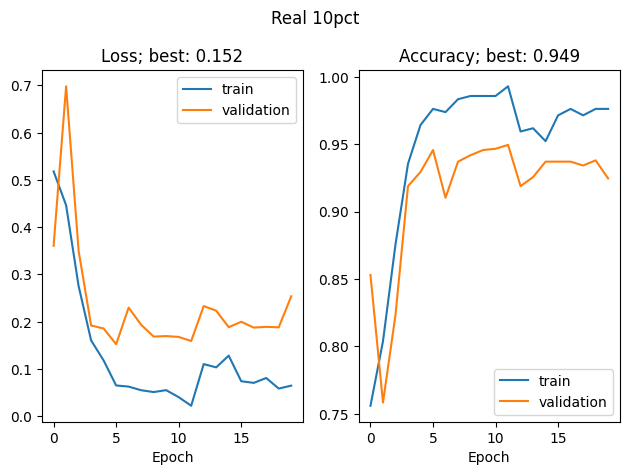

In [288]:
viz.plot_training_metrics(train_loss_real_10pct, train_acc_real_10pct, val_loss_real_10pct, val_acc_real_10pct, title="Real 10pct", save_dir=f"{results_folder}/plots")

#### Evaluate 10% real model on test set

In [289]:
# Load model
model_real_10pct = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_real_10pct.fc.in_features
model_real_10pct.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_real_10pct.load_state_dict(torch.load(f'{results_folder}/models/real_10pct.pth'))

<All keys matched successfully>

In [290]:
y_true_real_10pct, y_pred_real_10pct, test_accuracy_real_10pct, per_class_acc_real_10pct = train_clf.evaluate_model_on_test_set(
    model_real_10pct, data_loader=dataloaders_real_10pct['test'], class_names=class_names)

Accuracy for class: NORMAL is 57.3 %
Accuracy for class: PNEUMONIA is 92.1 %
Overall accuracy (Real 10pct): 79.0
Precision: 0.797
Recall: 0.747
F1 score: 0.759


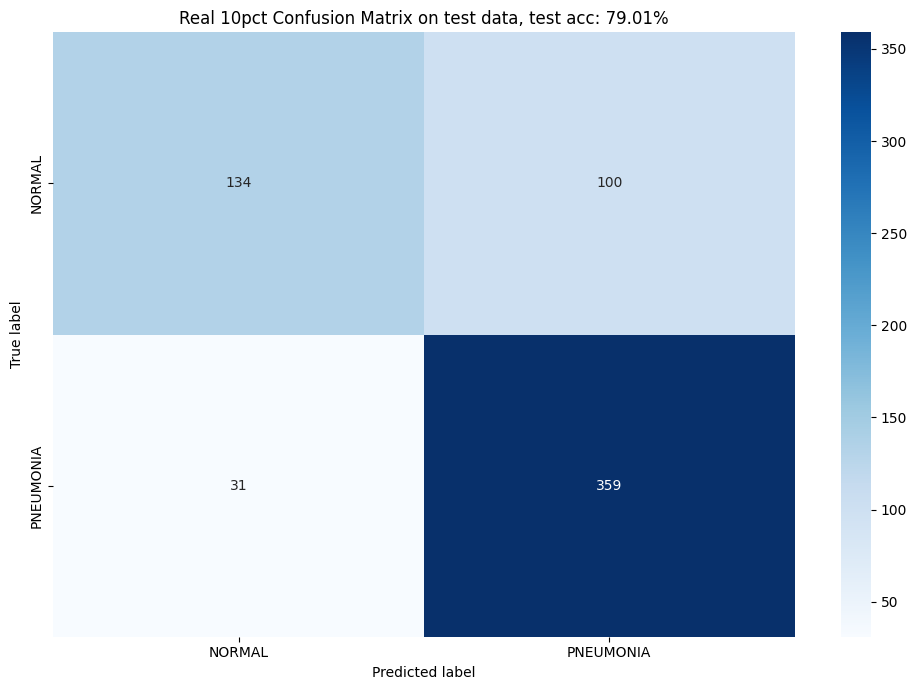

In [291]:
confusion_real_10pct, precision_real_10pct, recall_real_10pct, fscore_real_10pct, _ = train_clf.compute_metrics_on_test_set(y_true_real_10pct, y_pred_real_10pct)
viz.show_test_summary_metrics(
    test_accuracy_real_10pct, per_class_acc_real_10pct, confusion_real_10pct, precision_real_10pct, recall_real_10pct, fscore_real_10pct,
    "Real 10pct", class_names, save_dir=f"{results_folder}/plots")

## (10) 10% real, no geo data aug, weighted loss, no PT

In [292]:
labels_10pct = dataset.get_labels(dataloaders_real_10pct['train'])

In [293]:
class_weights_10pct = dataset.compute_class_weights(labels_10pct).to(device)
class_weights_10pct

tensor([0.7081, 0.2919], device='cuda:0')

In [294]:
model_real_10pct_weighted = resnet18(weights=ResNet18_Weights.DEFAULT)
# Change the output layer to have 2 outputs
num_ftrs = model_real_10pct_weighted.fc.in_features
model_real_10pct_weighted.fc = nn.Linear(num_ftrs, n_outputs)
criterion_weighted = nn.CrossEntropyLoss(weight=class_weights_10pct)
# Observe that all parameters are being optimized
optimizer_real_10pct_weighted = optim.SGD(model_real_10pct_weighted.parameters(), lr=lr, momentum=momentum)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_real_10pct_weighted = lr_scheduler.StepLR(optimizer_real_10pct_weighted, step_size=step_size, gamma=gamma)

In [295]:
model_real_10pct_weighted, hist_real_10pct_weighted = train_clf.train_model(
    model_real_10pct_weighted, criterion_weighted, optimizer_real_10pct_weighted,
    exp_lr_scheduler_real_10pct_weighted, dataloaders_real_10pct, dataset_sizes_real_10pct,
    results_folder, model_name="real_10pct_weighted", num_epochs=num_epochs)

Epoch 1/20
----------
Phase:  train
train loss: 0.5137; acc: 0.7081
Phase:  val
val loss: 0.3983; acc: 0.8539

Epoch 2/20
----------
Phase:  train
train loss: 0.2692; acc: 0.8923
Phase:  val
val loss: 0.4547; acc: 0.8138

Epoch 3/20
----------
Phase:  train
train loss: 0.2397; acc: 0.9211
Phase:  val
val loss: 0.4456; acc: 0.8386

Epoch 4/20
----------
Phase:  train
train loss: 0.1853; acc: 0.9282
Phase:  val
val loss: 0.2389; acc: 0.9389

Epoch 5/20
----------
Phase:  train
train loss: 0.2087; acc: 0.9330
Phase:  val
val loss: 0.6666; acc: 0.8844

Epoch 6/20
----------
Phase:  train
train loss: 0.2626; acc: 0.8684
Phase:  val
val loss: 0.5331; acc: 0.8701

Epoch 7/20
----------
Phase:  train
train loss: 0.2853; acc: 0.8876
Phase:  val
val loss: 0.5518; acc: 0.7994

Epoch 8/20
----------
Phase:  train
train loss: 0.1998; acc: 0.9234
Phase:  val
val loss: 0.3206; acc: 0.8997

Epoch 9/20
----------
Phase:  train
train loss: 0.1699; acc: 0.9402
Phase:  val
val loss: 0.2778; acc: 0.9169

E

In [296]:
train_loss_real_10pct_weighted, train_acc_real_10pct_weighted, val_loss_real_10pct_weighted, val_acc_real_10pct_weighted = hist_real_10pct_weighted

#### Analyze 10% real with weighted loss model performance

In [297]:
train_loss_real_10pct_weighted, train_acc_real_10pct_weighted, val_loss_real_10pct_weighted, val_acc_real_10pct_weighted = train_clf.load_training_metrics(
    f"{results_folder}/metrics/real_10pct_weighted.npz")

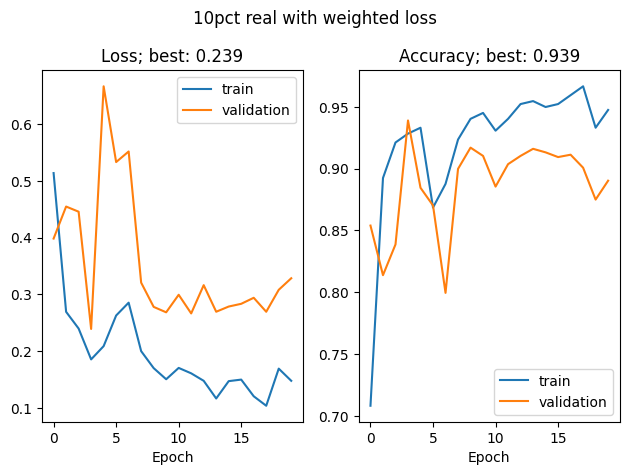

In [298]:
viz.plot_training_metrics(train_loss_real_10pct_weighted, train_acc_real_10pct_weighted, val_loss_real_10pct_weighted,
                          val_acc_real_10pct_weighted, title="10pct real with weighted loss", save_dir=f"{results_folder}/plots")

#### Evaluate 10% real with weighted loss model on test set

In [299]:
# Load model
model_real_10pct_weighted = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_real_10pct_weighted.fc.in_features
model_real_10pct_weighted.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_real_10pct_weighted.load_state_dict(torch.load(f'{results_folder}/models/real_10pct_weighted.pth'))

<All keys matched successfully>

In [300]:
y_true_real_10pct_weighted, y_pred_real_10pct_weighted, test_accuracy_real_10pct_weighted, per_class_acc_real_10pct_weighted = train_clf.evaluate_model_on_test_set(
    model_real_10pct_weighted, data_loader=dataloaders_real_10pct['test'], class_names=class_names)

Accuracy for class: NORMAL is 56.8 %
Accuracy for class: PNEUMONIA is 93.3 %
Overall accuracy (10pct real with weighted loss): 79.6
Precision: 0.810
Recall: 0.751
F1 score: 0.764


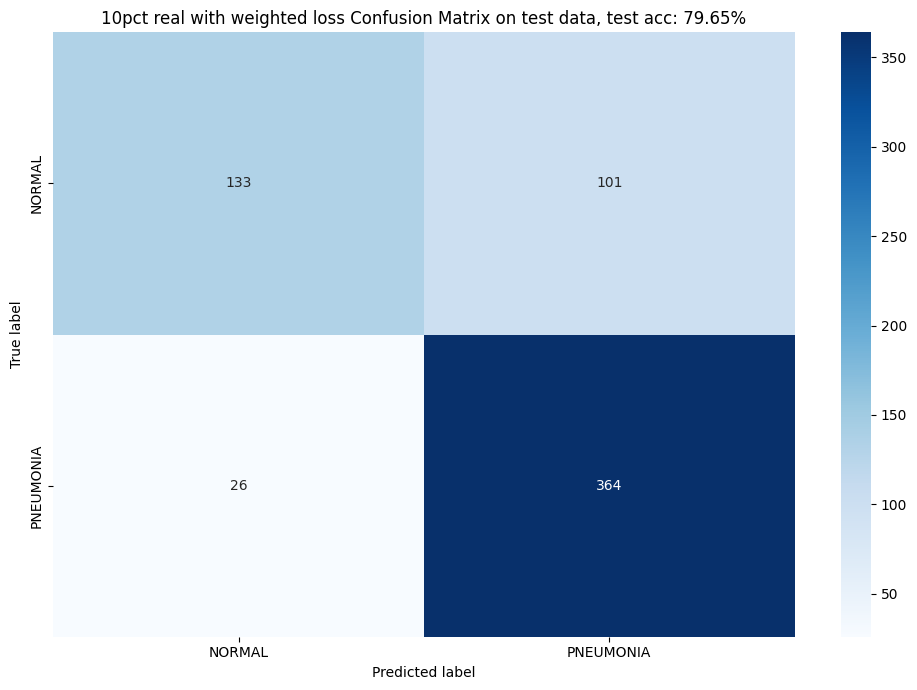

In [301]:
confusion_real_10pct_weighted, precision_real_10pct_weighted, recall_real_10pct_weighted, fscore_real_10pct_weighted, _ = train_clf.compute_metrics_on_test_set(
    y_true_real_10pct_weighted, y_pred_real_10pct_weighted)
viz.show_test_summary_metrics(
    test_accuracy_real_10pct_weighted, per_class_acc_real_10pct_weighted, confusion_real_10pct_weighted, precision_real_10pct_weighted,
    recall_real_10pct_weighted, fscore_real_10pct_weighted, "10pct real with weighted loss", class_names, save_dir=f"{results_folder}/plots")

## (11) Synth pretrain, no geo data aug, no weighted loss, FT on 10% real

In [302]:
model_synth_ft_real10pct = resnet18(weights=ResNet18_Weights.DEFAULT)
# Change the output layer to have 2 outputs
num_ftrs = model_synth_ft_real10pct.fc.in_features
model_synth_ft_real10pct.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_synth_ft_real10pct.load_state_dict(torch.load(f'{results_folder}/models/all_synthetic.pth'))

criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_synth_ft_real10pct = optim.SGD(model_synth_ft_real10pct.parameters(), lr=lr, momentum=momentum)
exp_lr_scheduler_synth_ft_real10pct = lr_scheduler.StepLR(optimizer_synth_ft_real10pct, step_size=step_size, gamma=gamma)

In [303]:
model_synth_ft_real10pct, hist_synth_ft_real10pct = train_clf.train_model(
    model_synth_ft_real10pct, criterion, optimizer_synth_ft_real10pct, exp_lr_scheduler_synth_ft_real10pct,
    dataloaders_real_10pct, dataset_sizes_real_10pct, results_folder, model_name="synth_ft_real10pct", num_epochs=num_epochs)

Epoch 1/20
----------
Phase:  train
train loss: 0.3834; acc: 0.8828
Phase:  val
val loss: 0.2820; acc: 0.8949

Epoch 2/20
----------
Phase:  train
train loss: 0.1266; acc: 0.9641
Phase:  val
val loss: 0.1543; acc: 0.9436

Epoch 3/20
----------
Phase:  train
train loss: 0.0868; acc: 0.9713
Phase:  val
val loss: 0.1985; acc: 0.9265

Epoch 4/20
----------
Phase:  train
train loss: 0.1670; acc: 0.9402
Phase:  val
val loss: 0.1574; acc: 0.9484

Epoch 5/20
----------
Phase:  train
train loss: 0.1339; acc: 0.9545
Phase:  val
val loss: 0.2238; acc: 0.9150

Epoch 6/20
----------
Phase:  train
train loss: 0.0803; acc: 0.9809
Phase:  val
val loss: 0.1556; acc: 0.9503

Epoch 7/20
----------
Phase:  train
train loss: 0.1002; acc: 0.9737
Phase:  val
val loss: 0.2791; acc: 0.8949

Epoch 8/20
----------
Phase:  train
train loss: 0.2040; acc: 0.9330
Phase:  val
val loss: 0.3127; acc: 0.8720

Epoch 9/20
----------
Phase:  train
train loss: 0.1627; acc: 0.9306
Phase:  val
val loss: 0.1786; acc: 0.9322

E

In [304]:
train_loss_synth_ft_real10pct, train_acc_synth_ft_real10pct, val_loss_synth_ft_real10pct, val_acc_synth_ft_real10pct = hist_synth_ft_real10pct

#### Analyze synthetic FT on 10% real performance

In [305]:
train_loss_synth_ft_real10pct, train_acc_synth_ft_real10pct, val_loss_synth_ft_real10pct, val_acc_synth_ft_real10pct = train_clf.load_training_metrics(
    f"{results_folder}/metrics/synth_ft_real10pct.npz")

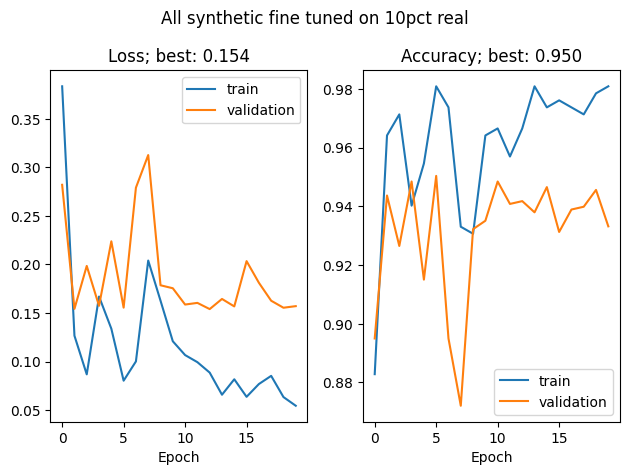

In [306]:
viz.plot_training_metrics(train_loss_synth_ft_real10pct, train_acc_synth_ft_real10pct, val_loss_synth_ft_real10pct,
                          val_acc_synth_ft_real10pct, title="All synthetic fine tuned on 10pct real", save_dir=f"{results_folder}/plots")

#### Evaluate synthetic FT on 10% real model on test set

In [307]:
# Load model
model_synth_ft_real10pct = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_synth_ft_real10pct.fc.in_features
model_synth_ft_real10pct.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_synth_ft_real10pct.load_state_dict(torch.load(f'{results_folder}/models/synth_ft_real10pct.pth'))

<All keys matched successfully>

In [308]:
y_true_synth_ft_real10pct, y_pred_synth_ft_real10pct, test_accuracy_synth_ft_real10pct, per_class_acc_synth_ft_real10pct = train_clf.evaluate_model_on_test_set(
    model_synth_ft_real10pct, data_loader=dataloaders_real_10pct['test'], class_names=class_names)

Accuracy for class: NORMAL is 60.3 %
Accuracy for class: PNEUMONIA is 92.3 %
Overall accuracy (All synthetic fine tuned on 10pct real): 80.3
Precision: 0.810
Recall: 0.763
F1 score: 0.775


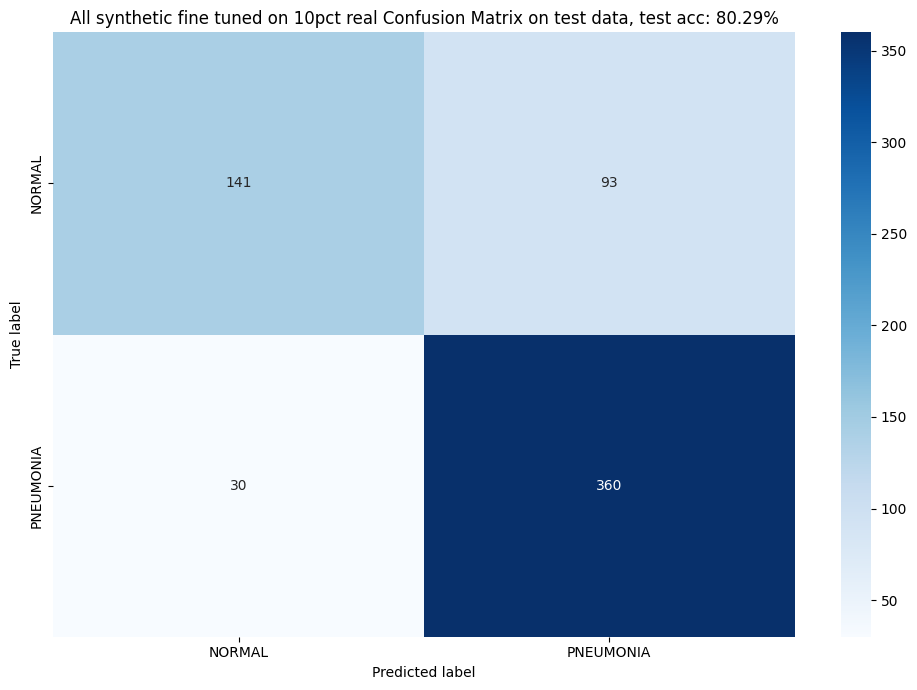

In [309]:
confusion_synth_ft_real10pct, precision_synth_ft_real10pct, recall_synth_ft_real10pct, fscore_synth_ft_real10pct, _ = train_clf.compute_metrics_on_test_set(
    y_true_synth_ft_real10pct, y_pred_synth_ft_real10pct)
viz.show_test_summary_metrics(
    test_accuracy_synth_ft_real10pct, per_class_acc_synth_ft_real10pct, confusion_synth_ft_real10pct, precision_synth_ft_real10pct,
    recall_synth_ft_real10pct, fscore_synth_ft_real10pct, "All synthetic fine tuned on 10pct real", class_names, save_dir=f"{results_folder}/plots")

## (12) Synth pretrain, no geo data aug, weighted loss, FT on 10% real

In [310]:
model_synth_ft_real_10pct_weighted = resnet18(weights=ResNet18_Weights.DEFAULT)
# Change the output layer to have 2 outputs
num_ftrs = model_synth_ft_real_10pct_weighted.fc.in_features
model_synth_ft_real_10pct_weighted.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_synth_ft_real_10pct_weighted.load_state_dict(torch.load(f'{results_folder}/models/all_synthetic.pth'))

criterion_weighted = nn.CrossEntropyLoss(weight=class_weights_10pct)
# Observe that all parameters are being optimized
optimizer_synth_ft_real_10pct_weighted = optim.SGD(model_synth_ft_real_10pct_weighted.parameters(), lr=lr, momentum=momentum)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_synth_ft_real_10pct_weighted = lr_scheduler.StepLR(optimizer_synth_ft_real_10pct_weighted, step_size=step_size, gamma=gamma)

In [311]:
model_synth_ft_real_10pct_weighted, hist_synth_ft_real_10pct_weighted = train_clf.train_model(
    model_synth_ft_real_10pct_weighted, criterion_weighted, optimizer_synth_ft_real_10pct_weighted,
    exp_lr_scheduler_synth_ft_real_10pct_weighted, dataloaders_real_10pct, dataset_sizes_real_10pct,
    results_folder, model_name="synth_ft_real_10pct_weighted", num_epochs=num_epochs)

Epoch 1/20
----------
Phase:  train
train loss: 0.2739; acc: 0.8780
Phase:  val
val loss: 0.3342; acc: 0.9236

Epoch 2/20
----------
Phase:  train
train loss: 0.1456; acc: 0.9569
Phase:  val
val loss: 0.3068; acc: 0.9169

Epoch 3/20
----------
Phase:  train
train loss: 0.1528; acc: 0.9426
Phase:  val
val loss: 0.6685; acc: 0.8138

Epoch 4/20
----------
Phase:  train
train loss: 0.1695; acc: 0.9378
Phase:  val
val loss: 0.5055; acc: 0.8902

Epoch 5/20
----------
Phase:  train
train loss: 0.1955; acc: 0.9258
Phase:  val
val loss: 1.0916; acc: 0.7899

Epoch 6/20
----------
Phase:  train
train loss: 0.5791; acc: 0.7344
Phase:  val
val loss: 13.0043; acc: 0.7526

Epoch 7/20
----------
Phase:  train
train loss: 0.6945; acc: 0.7727
Phase:  val
val loss: 5.5656; acc: 0.7584

Epoch 8/20
----------
Phase:  train
train loss: 0.3352; acc: 0.8589
Phase:  val
val loss: 0.6218; acc: 0.8500

Epoch 9/20
----------
Phase:  train
train loss: 0.2818; acc: 0.9043
Phase:  val
val loss: 0.3072; acc: 0.9007



#### Analyze synthetic FT on 10% real with weighted loss model performance

In [312]:
train_loss_synth_ft_real_10pct_weighted, train_acc_synth_ft_real_10pct_weighted, val_loss_synth_ft_real_10pct_weighted, val_acc_synth_ft_real_10pct_weighted = train_clf.load_training_metrics(
    f"{results_folder}/metrics/synth_ft_real_10pct_weighted.npz")

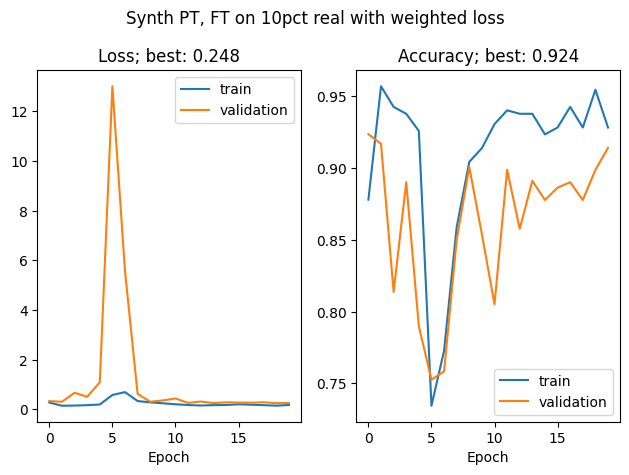

In [313]:
viz.plot_training_metrics(train_loss_synth_ft_real_10pct_weighted, train_acc_synth_ft_real_10pct_weighted, val_loss_synth_ft_real_10pct_weighted,
                          val_acc_synth_ft_real_10pct_weighted, title="Synth PT, FT on 10pct real with weighted loss", save_dir=f"{results_folder}/plots")

#### Evaluate synthetic FT on 10% real with weighted loss model on test set

In [314]:
# Load model
model_synth_ft_real_10pct_weighted = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_synth_ft_real_10pct_weighted.fc.in_features
model_synth_ft_real_10pct_weighted.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_synth_ft_real_10pct_weighted.load_state_dict(torch.load(f'{results_folder}/models/synth_ft_real_10pct_weighted.pth'))

<All keys matched successfully>

In [315]:
y_true_synth_ft_real_10pct_weighted, y_pred_synth_ft_real_10pct_weighted, test_accuracy_synth_ft_real_10pct_weighted, per_class_acc_synth_ft_real_10pct_weighted = train_clf.evaluate_model_on_test_set(
    model_synth_ft_real_10pct_weighted, data_loader=dataloaders_real_100pct['test'], class_names=class_names)

Accuracy for class: NORMAL is 46.6 %
Accuracy for class: PNEUMONIA is 94.6 %
Overall accuracy (Synth PT, FT on 10pct real with weighted loss): 76.6
Precision: 0.793
Recall: 0.706
F1 score: 0.717


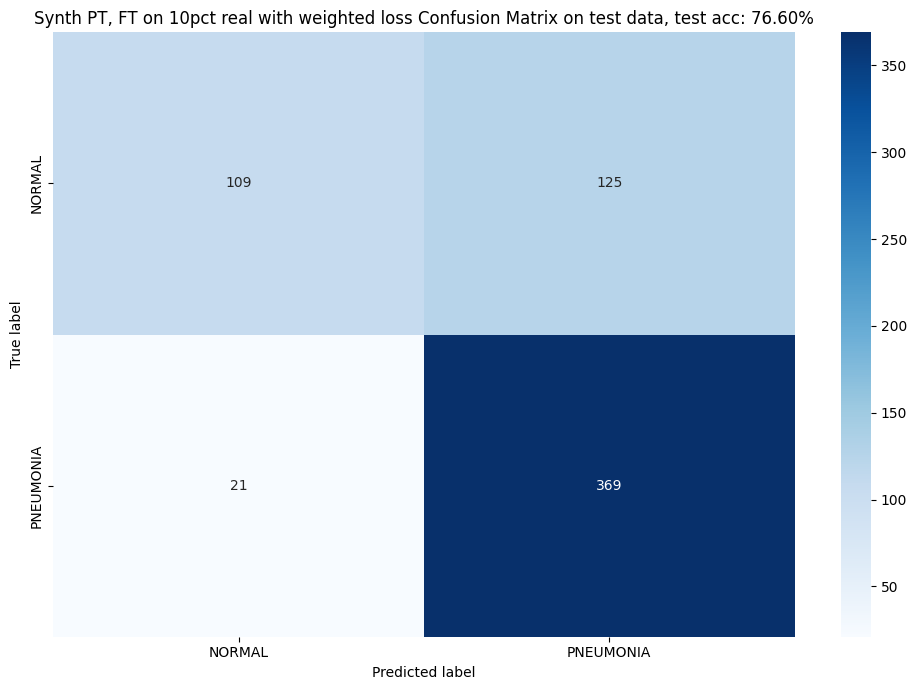

In [316]:
confusion_synth_ft_real_10pct_weighted, precision_synth_ft_real_10pct_weighted, recall_synth_ft_real_10pct_weighted, fscore_synth_ft_real_10pct_weighted, _ = train_clf.compute_metrics_on_test_set(
    y_true_synth_ft_real_10pct_weighted, y_pred_synth_ft_real_10pct_weighted)
viz.show_test_summary_metrics(
    test_accuracy_synth_ft_real_10pct_weighted, per_class_acc_synth_ft_real_10pct_weighted, confusion_synth_ft_real_10pct_weighted, precision_synth_ft_real_10pct_weighted,
    recall_synth_ft_real_10pct_weighted, fscore_synth_ft_real_10pct_weighted, "Synth PT, FT on 10pct real with weighted loss", class_names, save_dir=f"{results_folder}/plots")

## (13) 10% real, geometric data augmentation, no weighted loss, no PT

In [317]:
# dataloaders_real_100pct_geo_aug, dataset_sizes_real_100pct_geo_aug, _ = dataset.load_real_downscaled_normalized_xray_data(
#     data_dir_real, with_augmentation=True, batch_size=batch_size, return_val_set=True, load_as_rgb=True)
full_train_set_geo_aug = dataloaders_real_100pct['train'].dataset
# Sample 10% of the data from the full training set
train_set_10pct_geo_aug = torch.utils.data.Subset(full_train_set_geo_aug, torch.randperm(len(full_train_set_geo_aug))[:int(len(full_train_set_geo_aug)*0.1)])
# Create a new dataloader for the 10% training set
train_dataloader_10pct_geo_aug = torch.utils.data.DataLoader(train_set_10pct_geo_aug, batch_size=batch_size, shuffle=True, num_workers=4)

In [318]:
len(train_dataloader_10pct_geo_aug.dataset), len(dataloaders_real_100pct_geo_aug['train'].dataset)

(418, 4185)

In [319]:
dataloaders_real_10pct_geo_aug = {
    'train': train_dataloader_10pct_geo_aug,
    'val': dataloaders_real_100pct['val'],
    'test': dataloaders_real_100pct['test']
}
dataset_sizes_real_10pct_geo_aug = {
    'train': len(train_dataloader_10pct_geo_aug.dataset),
    'val': len(dataloaders_real_100pct['val'].dataset),
    'test': len(dataloaders_real_100pct['test'].dataset)
}

In [320]:
model_real_10pct_geo_aug = resnet18(weights=ResNet18_Weights.DEFAULT)
# Change the output layer to have 2 outputs
num_ftrs = model_real_10pct_geo_aug.fc.in_features
model_real_10pct_geo_aug.fc = nn.Linear(num_ftrs, n_outputs)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_real_10pct_geo_aug = optim.SGD(model_real_10pct_geo_aug.parameters(), lr=lr, momentum=momentum)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_real_10pct_geo_aug = lr_scheduler.StepLR(optimizer_real_10pct_geo_aug, step_size=step_size, gamma=gamma)

In [321]:
model_real_10pct_geo_aug, hist_real_10pct_geo_aug = train_clf.train_model(
    model_real_10pct_geo_aug, criterion, optimizer_real_10pct_geo_aug, exp_lr_scheduler_real_10pct_geo_aug,
    dataloaders_real_10pct_geo_aug, dataset_sizes_real_10pct_geo_aug, results_folder, model_name="real_10pct_geo_aug", num_epochs=num_epochs)

Epoch 1/20
----------
Phase:  train
train loss: 0.5141; acc: 0.7440
Phase:  val
val loss: 0.3919; acc: 0.8768

Epoch 2/20
----------
Phase:  train
train loss: 0.2003; acc: 0.9234
Phase:  val
val loss: 0.2757; acc: 0.9054

Epoch 3/20
----------
Phase:  train
train loss: 0.0778; acc: 0.9689
Phase:  val
val loss: 0.2473; acc: 0.9169

Epoch 4/20
----------
Phase:  train
train loss: 0.0863; acc: 0.9713
Phase:  val
val loss: 0.1842; acc: 0.9360

Epoch 5/20
----------
Phase:  train
train loss: 0.1352; acc: 0.9689
Phase:  val
val loss: 0.2220; acc: 0.9293

Epoch 6/20
----------
Phase:  train
train loss: 0.0652; acc: 0.9833
Phase:  val
val loss: 0.2475; acc: 0.9188

Epoch 7/20
----------
Phase:  train
train loss: 0.1577; acc: 0.9354
Phase:  val
val loss: 1.7307; acc: 0.7775

Epoch 8/20
----------
Phase:  train
train loss: 0.2450; acc: 0.9306
Phase:  val
val loss: 0.4908; acc: 0.8558

Epoch 9/20
----------
Phase:  train
train loss: 0.1960; acc: 0.9402
Phase:  val
val loss: 0.2741; acc: 0.9102

E

#### Analyze 10% real with geo aug model performance

In [322]:
train_loss_real_10pct_geo_aug, train_acc_real_10pct_geo_aug, val_loss_real_10pct_geo_aug, val_acc_real_10pct_geo_aug = train_clf.load_training_metrics(
    f"{results_folder}/metrics/real_10pct_geo_aug.npz")

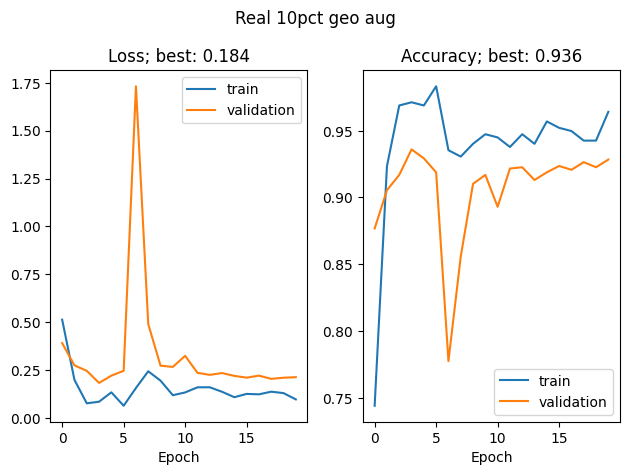

In [323]:
viz.plot_training_metrics(train_loss_real_10pct_geo_aug, train_acc_real_10pct_geo_aug, val_loss_real_10pct_geo_aug,
                          val_acc_real_10pct_geo_aug, title="Real 10pct geo aug", save_dir=f"{results_folder}/plots")

#### Evaluate 10% real with geo aug model on test set

In [324]:
# Load model
model_real_10pct_geo_aug = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_real_10pct_geo_aug.fc.in_features
model_real_10pct_geo_aug.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_real_10pct_geo_aug.load_state_dict(torch.load(f'{results_folder}/models/real_10pct_geo_aug.pth'))

<All keys matched successfully>

In [325]:
y_true_real_10pct_geo_aug, y_pred_real_10pct_geo_aug, test_accuracy_real_10pct_geo_aug, per_class_acc_real_10pct_geo_aug = train_clf.evaluate_model_on_test_set(
    model_real_10pct_geo_aug, data_loader=dataloaders_real_10pct_geo_aug['test'], class_names=class_names)

Accuracy for class: NORMAL is 59.4 %
Accuracy for class: PNEUMONIA is 93.3 %
Overall accuracy (Real 10pct geo aug): 80.6
Precision: 0.818
Recall: 0.764
F1 score: 0.777


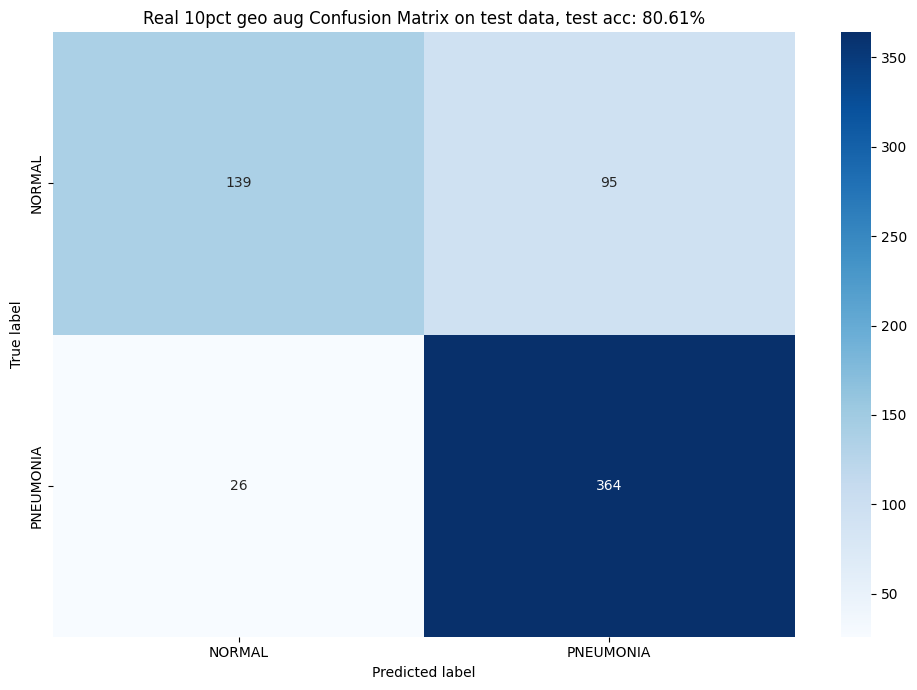

In [326]:
confusion_real_10pct_geo_aug, precision_real_10pct_geo_aug, recall_real_10pct_geo_aug, fscore_real_10pct_geo_aug, _ = train_clf.compute_metrics_on_test_set(y_true_real_10pct_geo_aug, y_pred_real_10pct_geo_aug)
viz.show_test_summary_metrics(
    test_accuracy_real_10pct_geo_aug, per_class_acc_real_10pct_geo_aug, confusion_real_10pct_geo_aug, precision_real_10pct_geo_aug, recall_real_10pct_geo_aug, fscore_real_10pct_geo_aug,
    "Real 10pct geo aug", class_names, save_dir=f"{results_folder}/plots")

## (14) 10% real, geo data aug, weighted loss, no PT

In [327]:
model_real_10pct_weighted_geo_aug = resnet18(weights=ResNet18_Weights.DEFAULT)
# Change the output layer to have 2 outputs
num_ftrs = model_real_10pct_weighted_geo_aug.fc.in_features
model_real_10pct_weighted_geo_aug.fc = nn.Linear(num_ftrs, n_outputs)
criterion_weighted = nn.CrossEntropyLoss(weight=class_weights_10pct)
# Observe that all parameters are being optimized
optimizer_real_10pct_weighted_geo_aug = optim.SGD(model_real_10pct_weighted_geo_aug.parameters(), lr=lr, momentum=momentum)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_real_10pct_weighted_geo_aug = lr_scheduler.StepLR(optimizer_real_10pct_weighted_geo_aug, step_size=step_size, gamma=gamma)

In [328]:
model_real_10pct_weighted_geo_aug, hist_real_10pct_weighted_geo_aug = train_clf.train_model(
    model_real_10pct_weighted_geo_aug, criterion_weighted, optimizer_real_10pct_weighted_geo_aug,
    exp_lr_scheduler_real_10pct_weighted_geo_aug, dataloaders_real_10pct_geo_aug, dataset_sizes_real_10pct_geo_aug,
    results_folder, model_name="real_10pct_weighted_geo_aug", num_epochs=num_epochs)

Epoch 1/20
----------
Phase:  train
train loss: 0.5426; acc: 0.7679
Phase:  val
val loss: 0.3892; acc: 0.8415

Epoch 2/20
----------
Phase:  train
train loss: 0.1655; acc: 0.9306
Phase:  val
val loss: 0.2769; acc: 0.9226

Epoch 3/20
----------
Phase:  train
train loss: 0.4242; acc: 0.8852
Phase:  val
val loss: 0.3462; acc: 0.8701

Epoch 4/20
----------
Phase:  train
train loss: 0.1888; acc: 0.9187
Phase:  val
val loss: 0.2041; acc: 0.9245

Epoch 5/20
----------
Phase:  train
train loss: 0.1097; acc: 0.9617
Phase:  val
val loss: 0.2005; acc: 0.9331

Epoch 6/20
----------
Phase:  train
train loss: 0.3239; acc: 0.8517
Phase:  val
val loss: 0.6384; acc: 0.8615

Epoch 7/20
----------
Phase:  train
train loss: 0.2183; acc: 0.9402
Phase:  val
val loss: 0.5667; acc: 0.7937

Epoch 8/20
----------
Phase:  train
train loss: 0.2326; acc: 0.9019
Phase:  val
val loss: 0.3762; acc: 0.8357

Epoch 9/20
----------
Phase:  train
train loss: 0.2438; acc: 0.9067
Phase:  val
val loss: 0.3004; acc: 0.8921

E

#### Analyze 10% real with geo aug and weighted loss model performance

In [329]:
train_loss_real_10pct_weighted_geo_aug, train_acc_real_10pct_weighted_geo_aug, val_loss_real_10pct_weighted_geo_aug, val_acc_real_10pct_weighted_geo_aug = train_clf.load_training_metrics(
    f"{results_folder}/metrics/real_10pct_weighted_geo_aug.npz")

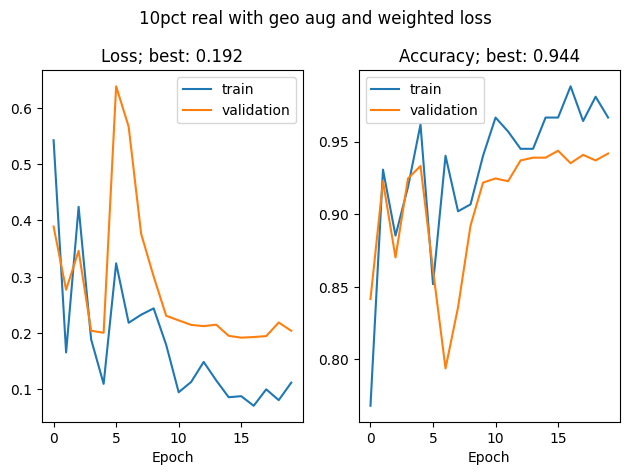

In [330]:
viz.plot_training_metrics(train_loss_real_10pct_weighted_geo_aug, train_acc_real_10pct_weighted_geo_aug,
                          val_loss_real_10pct_weighted_geo_aug, val_acc_real_10pct_weighted_geo_aug,
                          title="10pct real with geo aug and weighted loss", save_dir=f"{results_folder}/plots")

#### Evaluate 10% real with geo aug and weighted loss model on test set

In [331]:
# Load model
model_real_10pct_weighted_geo_aug = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_real_10pct_weighted_geo_aug.fc.in_features
model_real_10pct_weighted_geo_aug.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_real_10pct_weighted_geo_aug.load_state_dict(torch.load(f'{results_folder}/models/real_10pct_weighted_geo_aug.pth'))

<All keys matched successfully>

In [332]:
y_true_real_10pct_weighted_geo_aug, y_pred_real_10pct_weighted_geo_aug, test_accuracy_real_10pct_weighted_geo_aug, per_class_acc_real_10pct_weighted_geo_aug = train_clf.evaluate_model_on_test_set(
    model_real_10pct_weighted_geo_aug, data_loader=dataloaders_real_10pct_geo_aug['test'], class_names=class_names)

Accuracy for class: NORMAL is 62.4 %
Accuracy for class: PNEUMONIA is 88.5 %
Overall accuracy (10pct real with geo aug and weighted loss): 78.7
Precision: 0.781
Recall: 0.754
F1 score: 0.763


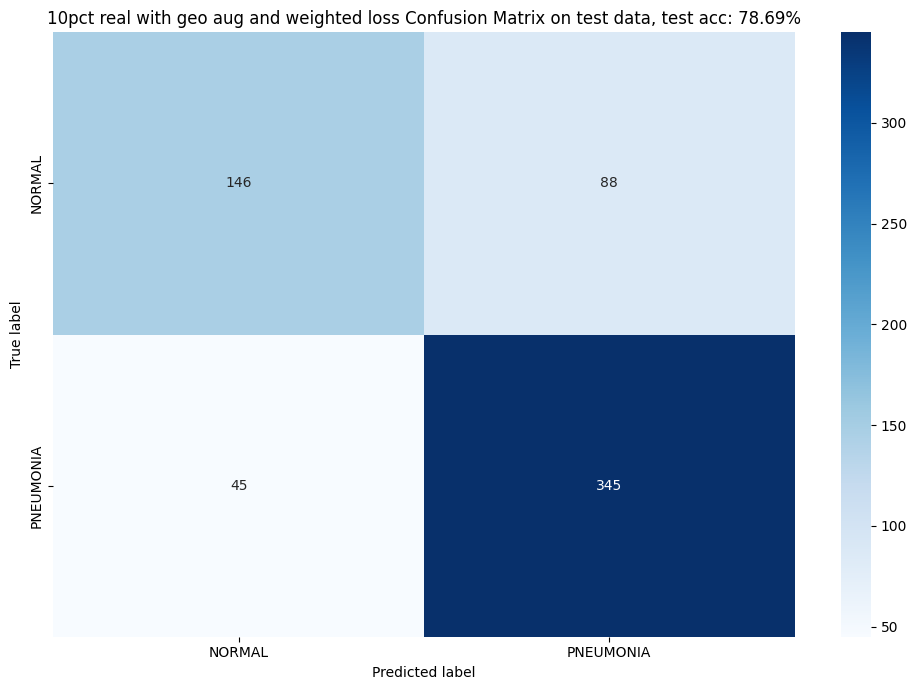

In [333]:
confusion_real_10pct_weighted_geo_aug, precision_real_10pct_weighted_geo_aug, recall_real_10pct_weighted_geo_aug, fscore_real_10pct_weighted_geo_aug, _ = train_clf.compute_metrics_on_test_set(
    y_true_real_10pct_weighted_geo_aug, y_pred_real_10pct_weighted_geo_aug)
viz.show_test_summary_metrics(
    test_accuracy_real_10pct_weighted_geo_aug, per_class_acc_real_10pct_weighted_geo_aug, confusion_real_10pct_weighted_geo_aug, precision_real_10pct_weighted_geo_aug,
    recall_real_10pct_weighted_geo_aug, fscore_real_10pct_weighted_geo_aug, "10pct real with geo aug and weighted loss", class_names, save_dir=f"{results_folder}/plots")

## (15) Synth PT, geo data augmentation, no weighted loss, FT on 10% real

In [334]:
model_synth_ft_real10pct_geo_aug = resnet18(weights=ResNet18_Weights.DEFAULT)
# Change the output layer to have 2 outputs
num_ftrs = model_synth_ft_real10pct_geo_aug.fc.in_features
model_synth_ft_real10pct_geo_aug.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_synth_ft_real10pct_geo_aug.load_state_dict(torch.load(f'{results_folder}/models/all_synthetic.pth'))

criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_synth_ft_real10pct_geo_aug = optim.SGD(model_synth_ft_real10pct_geo_aug.parameters(), lr=lr, momentum=momentum)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_synth_ft_real10pct_geo_aug = lr_scheduler.StepLR(optimizer_synth_ft_real10pct_geo_aug, step_size=step_size, gamma=gamma)

In [335]:
model_synth_ft_real10pct_geo_aug, hist_synth_ft_real10pct_geo_aug = train_clf.train_model(
    model_synth_ft_real10pct_geo_aug, criterion, optimizer_synth_ft_real10pct_geo_aug, exp_lr_scheduler_synth_ft_real10pct_geo_aug,
    dataloaders_real_10pct_geo_aug, dataset_sizes_real_10pct_geo_aug, results_folder, model_name="synth_ft_real10pct_geo_aug", num_epochs=num_epochs)

Epoch 1/20
----------
Phase:  train
train loss: 0.3213; acc: 0.8852
Phase:  val
val loss: 0.3654; acc: 0.8883

Epoch 2/20
----------
Phase:  train
train loss: 0.1717; acc: 0.9378
Phase:  val
val loss: 0.3597; acc: 0.8749

Epoch 3/20
----------
Phase:  train
train loss: 0.2016; acc: 0.9330
Phase:  val
val loss: 0.5679; acc: 0.7612

Epoch 4/20
----------
Phase:  train
train loss: 0.1189; acc: 0.9593
Phase:  val
val loss: 0.1393; acc: 0.9503

Epoch 5/20
----------
Phase:  train
train loss: 0.0619; acc: 0.9785
Phase:  val
val loss: 0.1506; acc: 0.9503

Epoch 6/20
----------
Phase:  train
train loss: 0.0393; acc: 0.9833
Phase:  val
val loss: 0.1390; acc: 0.9551

Epoch 7/20
----------
Phase:  train
train loss: 0.0399; acc: 0.9928
Phase:  val
val loss: 0.1607; acc: 0.9513

Epoch 8/20
----------
Phase:  train
train loss: 0.0146; acc: 0.9976
Phase:  val
val loss: 0.1680; acc: 0.9484

Epoch 9/20
----------
Phase:  train
train loss: 0.0286; acc: 0.9928
Phase:  val
val loss: 0.1385; acc: 0.9570

E

#### Analyze synthetic FT on 10% real with geo aug model performance

In [336]:
train_loss_synth_ft_real10pct_geo_aug, train_acc_synth_ft_real10pct_geo_aug, val_loss_synth_ft_real10pct_geo_aug, val_acc_synth_ft_real10pct_geo_aug = train_clf.load_training_metrics(
    f"{results_folder}/metrics/synth_ft_real10pct_geo_aug.npz")

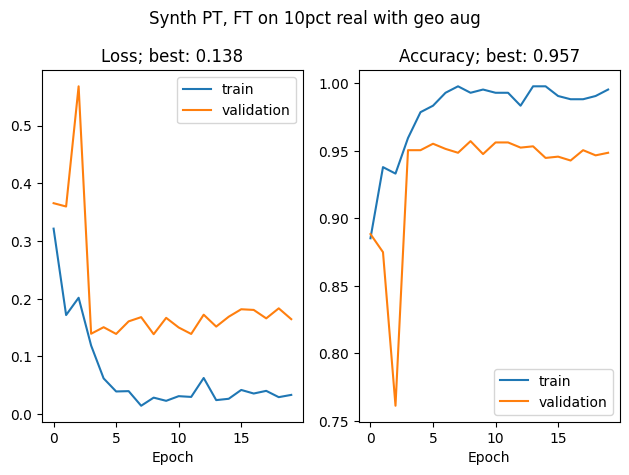

In [337]:
viz.plot_training_metrics(train_loss_synth_ft_real10pct_geo_aug, train_acc_synth_ft_real10pct_geo_aug, val_loss_synth_ft_real10pct_geo_aug,
                          val_acc_synth_ft_real10pct_geo_aug, title="Synth PT, FT on 10pct real with geo aug", save_dir=f"{results_folder}/plots")

#### Evaluate synthetic FT, 10% real, geo aug model on test set

In [338]:
# Load model
model_synth_ft_real10pct_geo_aug = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_synth_ft_real10pct_geo_aug.fc.in_features
model_synth_ft_real10pct_geo_aug.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_synth_ft_real10pct_geo_aug.load_state_dict(torch.load(f'{results_folder}/models/synth_ft_real10pct_geo_aug.pth'))

<All keys matched successfully>

In [339]:
y_true_synth_ft_real10pct_geo_aug, y_pred_synth_ft_real10pct_geo_aug, test_accuracy_synth_ft_real10pct_geo_aug, per_class_acc_synth_ft_real10pct_geo_aug = train_clf.evaluate_model_on_test_set(
    model_synth_ft_real10pct_geo_aug, data_loader=dataloaders_real_10pct_geo_aug['test'], class_names=class_names)

Accuracy for class: NORMAL is 53.4 %
Accuracy for class: PNEUMONIA is 95.9 %
Overall accuracy (Synth PT, FT on 10pct real with geo aug): 80.0
Precision: 0.830
Recall: 0.747
F1 score: 0.762


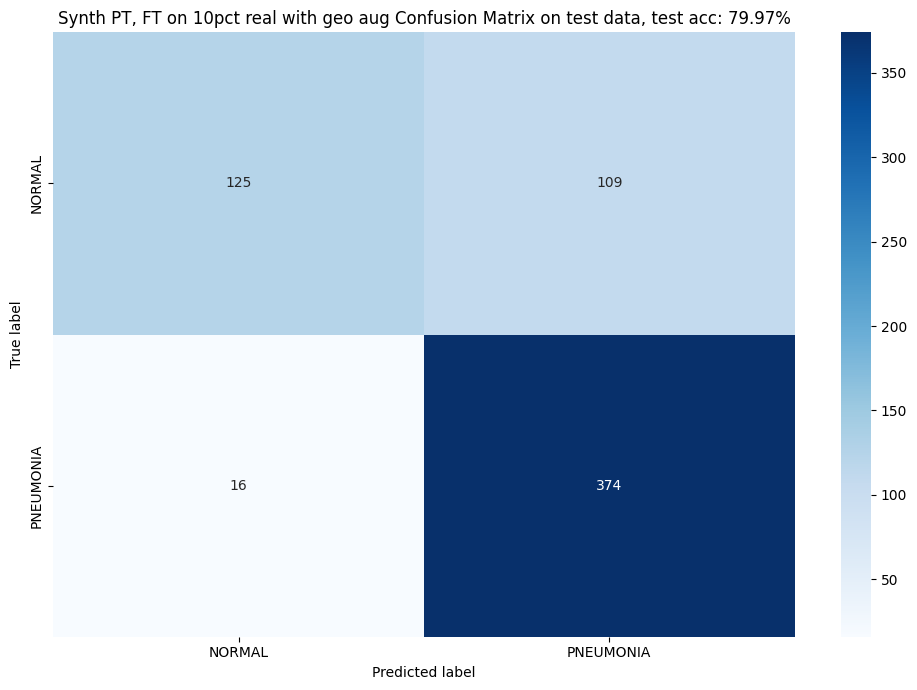

In [340]:
confusion_synth_ft_real10pct_geo_aug, precision_synth_ft_real10pct_geo_aug, recall_synth_ft_real10pct_geo_aug, fscore_synth_ft_real10pct_geo_aug, _ = train_clf.compute_metrics_on_test_set(y_true_synth_ft_real10pct_geo_aug, y_pred_synth_ft_real10pct_geo_aug)
viz.show_test_summary_metrics(
    test_accuracy_synth_ft_real10pct_geo_aug, per_class_acc_synth_ft_real10pct_geo_aug, confusion_synth_ft_real10pct_geo_aug,
    precision_synth_ft_real10pct_geo_aug, recall_synth_ft_real10pct_geo_aug, fscore_synth_ft_real10pct_geo_aug,
    "Synth PT, FT on 10pct real with geo aug", class_names, save_dir=f"{results_folder}/plots")

## (16) Synth PT, geo data aug, weighted loss, FT on 10% real

In [341]:
model_synth_ft_real10pct_geo_aug_weighted = resnet18(weights=ResNet18_Weights.DEFAULT)
# Change the output layer to have 2 outputs
num_ftrs = model_synth_ft_real10pct_geo_aug_weighted.fc.in_features
model_synth_ft_real10pct_geo_aug_weighted.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_synth_ft_real10pct_geo_aug_weighted.load_state_dict(torch.load(f'{results_folder}/models/all_synthetic.pth'))

criterion_weighted = nn.CrossEntropyLoss(weight=class_weights_10pct)
# Observe that all parameters are being optimized
optimizer_synth_ft_real10pct_geo_aug_weighted = optim.SGD(model_synth_ft_real10pct_geo_aug_weighted.parameters(), lr=lr, momentum=momentum)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_synth_ft_real10pct_geo_aug_weighted = lr_scheduler.StepLR(optimizer_synth_ft_real10pct_geo_aug_weighted, step_size=step_size, gamma=gamma)

In [342]:
model_synth_ft_real10pct_geo_aug_weighted, hist_synth_ft_real10pct_geo_aug_weighted = train_clf.train_model(
    model_synth_ft_real10pct_geo_aug_weighted, criterion_weighted, optimizer_synth_ft_real10pct_geo_aug_weighted,
    exp_lr_scheduler_synth_ft_real10pct_geo_aug_weighted, dataloaders_real_10pct_geo_aug, dataset_sizes_real_10pct_geo_aug,
    results_folder, model_name="synth_ft_real10pct_geo_aug_weighted", num_epochs=num_epochs)

Epoch 1/20
----------
Phase:  train
train loss: 0.3545; acc: 0.8684
Phase:  val
val loss: 1.7728; acc: 0.7975

Epoch 2/20
----------
Phase:  train
train loss: 0.5837; acc: 0.7895
Phase:  val
val loss: 0.5914; acc: 0.7287

Epoch 3/20
----------
Phase:  train
train loss: 0.3599; acc: 0.8804
Phase:  val
val loss: 0.5638; acc: 0.6734

Epoch 4/20
----------
Phase:  train
train loss: 0.2878; acc: 0.8708
Phase:  val
val loss: 0.3682; acc: 0.8691

Epoch 5/20
----------
Phase:  train
train loss: 0.3032; acc: 0.8708
Phase:  val
val loss: 1.6342; acc: 0.7994

Epoch 6/20
----------
Phase:  train
train loss: 0.2753; acc: 0.9043
Phase:  val
val loss: 0.3417; acc: 0.8930

Epoch 7/20
----------
Phase:  train
train loss: 0.3337; acc: 0.8565
Phase:  val
val loss: 0.3224; acc: 0.9160

Epoch 8/20
----------
Phase:  train
train loss: 0.2983; acc: 0.8995
Phase:  val
val loss: 0.2449; acc: 0.9312

Epoch 9/20
----------
Phase:  train
train loss: 0.2510; acc: 0.9019
Phase:  val
val loss: 0.2500; acc: 0.9226

E

#### Analyze synth PT, FT on 10% real, geo aug and weighted loss model performance

In [343]:
train_loss_synth_ft_real10pct_geo_aug_weighted, train_acc_synth_ft_real10pct_geo_aug_weighted, val_loss_synth_ft_real10pct_geo_aug_weighted, val_acc_synth_ft_real10pct_geo_aug_weighted = train_clf.load_training_metrics(
    f"{results_folder}/metrics/synth_ft_real10pct_geo_aug_weighted.npz")

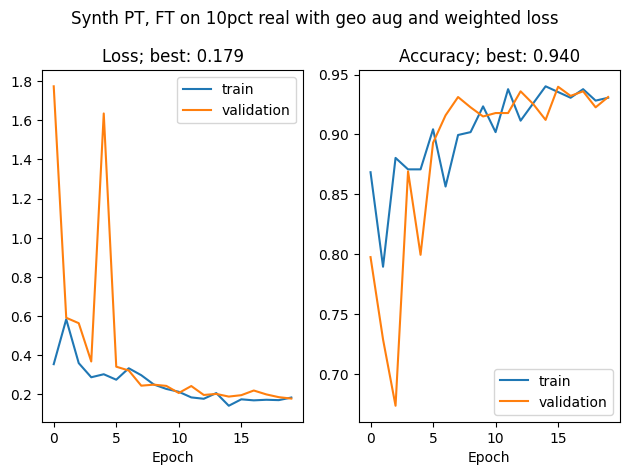

In [344]:
viz.plot_training_metrics(train_loss_synth_ft_real10pct_geo_aug_weighted, train_acc_synth_ft_real10pct_geo_aug_weighted,
                          val_loss_synth_ft_real10pct_geo_aug_weighted, val_acc_synth_ft_real10pct_geo_aug_weighted,
                          title="Synth PT, FT on 10pct real with geo aug and weighted loss", save_dir=f"{results_folder}/plots")

#### Evaluate synth PT, FT on 10% real, geo aug and weighted loss model on test set

In [345]:
# Load model
model_synth_ft_real10pct_geo_aug_weighted = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_synth_ft_real10pct_geo_aug_weighted.fc.in_features
model_synth_ft_real10pct_geo_aug_weighted.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_synth_ft_real10pct_geo_aug_weighted.load_state_dict(torch.load(f'{results_folder}/models/synth_ft_real10pct_geo_aug_weighted.pth'))

<All keys matched successfully>

In [346]:
y_true_synth_ft_real10pct_geo_aug_weighted, y_pred_synth_ft_real10pct_geo_aug_weighted, test_accuracy_synth_ft_real10pct_geo_aug_weighted, per_class_acc_synth_ft_real10pct_geo_aug_weighted = train_clf.evaluate_model_on_test_set(
    model_synth_ft_real10pct_geo_aug_weighted, data_loader=dataloaders_real_10pct_geo_aug['test'], class_names=class_names)

Accuracy for class: NORMAL is 64.1 %
Accuracy for class: PNEUMONIA is 89.0 %
Overall accuracy (Synth PT, FT on 10pct real with geo aug and weighted loss): 79.6
Precision: 0.791
Recall: 0.765
F1 score: 0.774


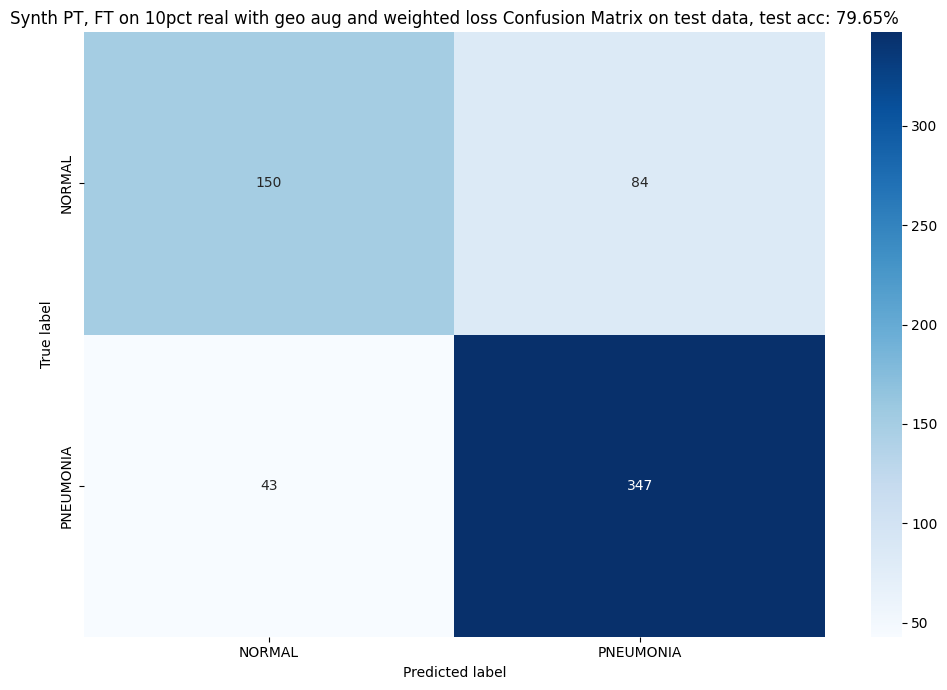

In [347]:
confusion_synth_ft_real10pct_geo_aug_weighted, precision_synth_ft_real10pct_geo_aug_weighted, recall_synth_ft_real10pct_geo_aug_weighted, fscore_synth_ft_real10pct_geo_aug_weighted, _ = train_clf.compute_metrics_on_test_set(
    y_true_synth_ft_real10pct_geo_aug_weighted, y_pred_synth_ft_real10pct_geo_aug_weighted)
viz.show_test_summary_metrics(
    test_accuracy_synth_ft_real10pct_geo_aug_weighted, per_class_acc_synth_ft_real10pct_geo_aug_weighted, confusion_synth_ft_real10pct_geo_aug_weighted,
    precision_synth_ft_real10pct_geo_aug_weighted, recall_synth_ft_real10pct_geo_aug_weighted, fscore_synth_ft_real10pct_geo_aug_weighted,
    "Synth PT, FT on 10pct real with geo aug and weighted loss", class_names, save_dir=f"{results_folder}/plots")

# Analysis (OUT OF DATE, COPIED FROM ASSIGNMENT 1, NEEDS TO BE UDPATED)

## Show some failure cases for each model

In [ ]:
import evaluate

In [ ]:
import torchvision.transforms as transforms

### Scratch models

#### Baseline

In [39]:
scratch_baseline_misclassified = evaluate.get_misclassified_images(model_scratch, dataloaders['test'])

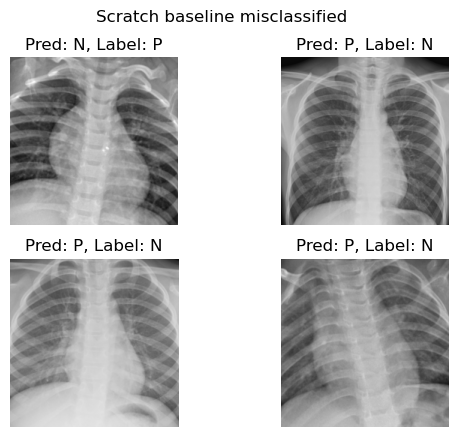

In [74]:
viz.show_misclassified_images(scratch_baseline_misclassified, class_names, mean, std, "Scratch baseline misclassified")

#### Weighted loss

In [57]:
scratch_weighted_misclassified = evaluate.get_misclassified_images(model_scratch_weighted, dataloaders['test'])

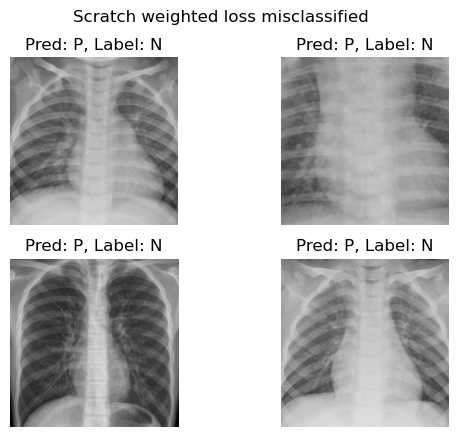

In [75]:
viz.show_misclassified_images(scratch_weighted_misclassified, class_names, mean, std, "Scratch weighted loss misclassified")

#### Cutmix

In [76]:
scratch_cutmix_misclassified = evaluate.get_misclassified_images(model_scratch_cutmix, dataloaders['test'])

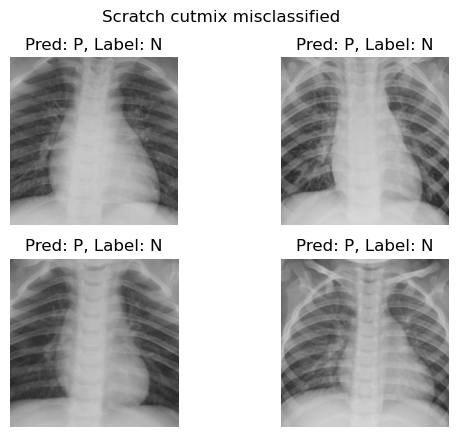

In [82]:
viz.show_misclassified_images(scratch_cutmix_misclassified, class_names, mean, std, "Scratch cutmix misclassified")

#### Cutmix and weighted loss

In [61]:
scratch_cutmix_weighted_misclassified = evaluate.get_misclassified_images(model_scratch_cutmix_weighted, dataloaders['test'])

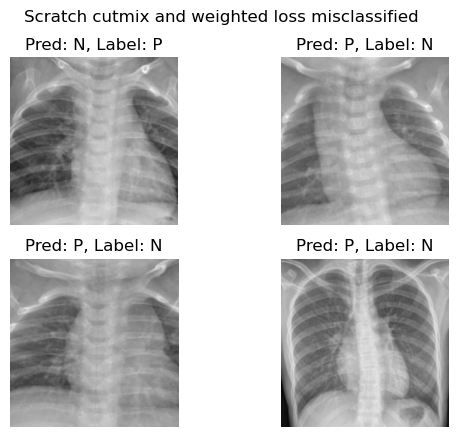

In [77]:
viz.show_misclassified_images(scratch_cutmix_weighted_misclassified, class_names, mean, std, "Scratch cutmix and weighted loss misclassified")

### Pretrained models

In [64]:
pretrain_baseline_misclassified = evaluate.get_misclassified_images(model_ft, dataloaders['test'])

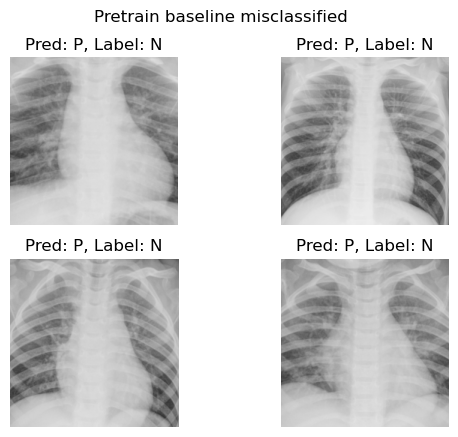

In [78]:
viz.show_misclassified_images(pretrain_baseline_misclassified, class_names, mean, std, "Pretrain baseline misclassified")

#### Weighted loss

In [66]:
pretrain_weighted_misclassified = evaluate.get_misclassified_images(model_ft_weighted, dataloaders['test'])

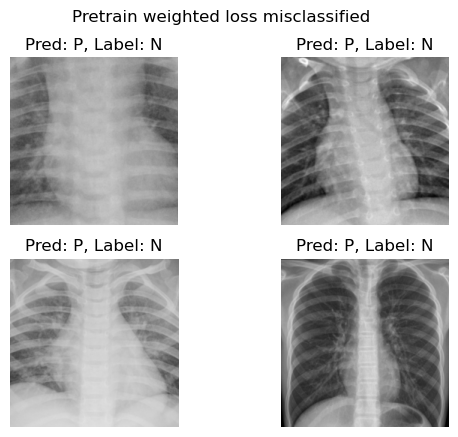

In [79]:
viz.show_misclassified_images(pretrain_weighted_misclassified, class_names, mean, std, "Pretrain weighted loss misclassified")

#### Cutmix

In [68]:
pretrain_cutmix_misclassified = evaluate.get_misclassified_images(model_ft_cutmix, dataloaders['test'])

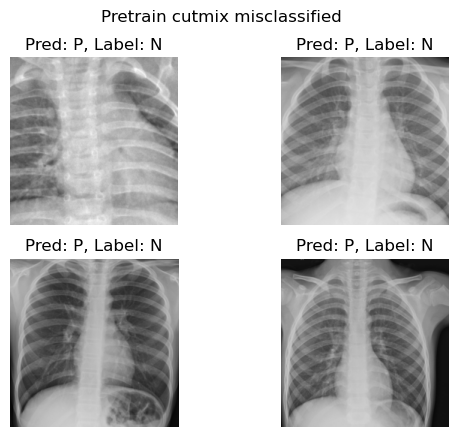

In [80]:
viz.show_misclassified_images(pretrain_cutmix_misclassified, class_names, mean, std, "Pretrain cutmix misclassified")

#### Cutmix and weighted loss

In [70]:
pretrain_cutmix_weighted_misclassified = evaluate.get_misclassified_images(model_ft_cutmix_weighted, dataloaders['test'])

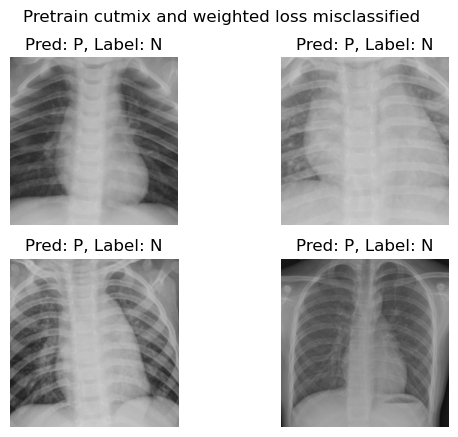

In [81]:
viz.show_misclassified_images(pretrain_cutmix_weighted_misclassified, class_names, mean, std, "Pretrain cutmix and weighted loss misclassified")

### Gradcam

In [86]:
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image

In [100]:
model_scratch = model_scratch.to(device)
cam_extractor = SmoothGradCAMpp(model_scratch)

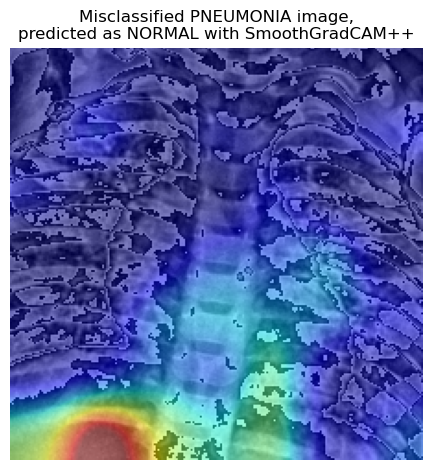

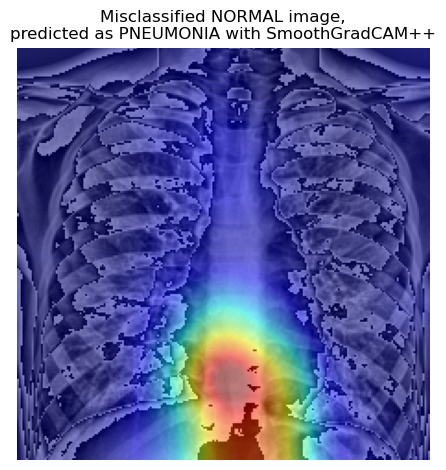

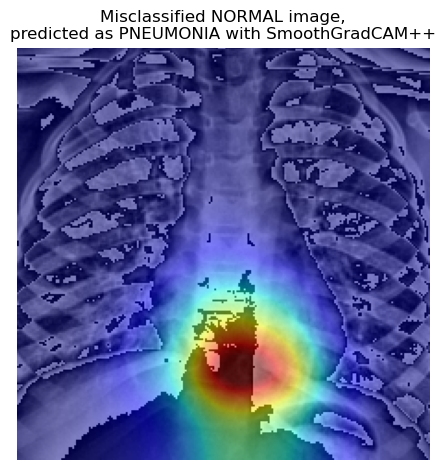

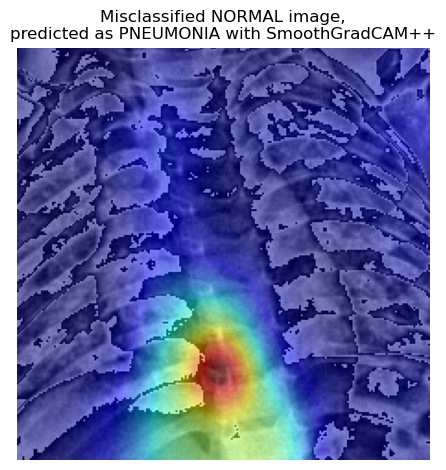

In [117]:
for img, label, pred in scratch_baseline_misclassified:
  # Preprocess your data and feed it to the model
  out = model_scratch(img.unsqueeze(0).to(device))
  # Retrieve the CAM by passing the class index and the model output
  activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
  # Visualize the CAM
  # plt.imshow(activation_map[0].squeeze(0).cpu().numpy())

  # Resize the CAM and overlay it
  result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
  # Display it
  plt.title(f"Misclassified {class_names[label]} image,\npredicted as {class_names[pred]} with SmoothGradCAM++")
  plt.imshow(result); plt.axis('off'); plt.tight_layout()
  # Save image before showing
  plt.savefig(f"plots/scratch_baseline_misclassified_{label}_{pred}.png")
  plt.show()